In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']=300
%config InlineBackend.figure_format='retina'

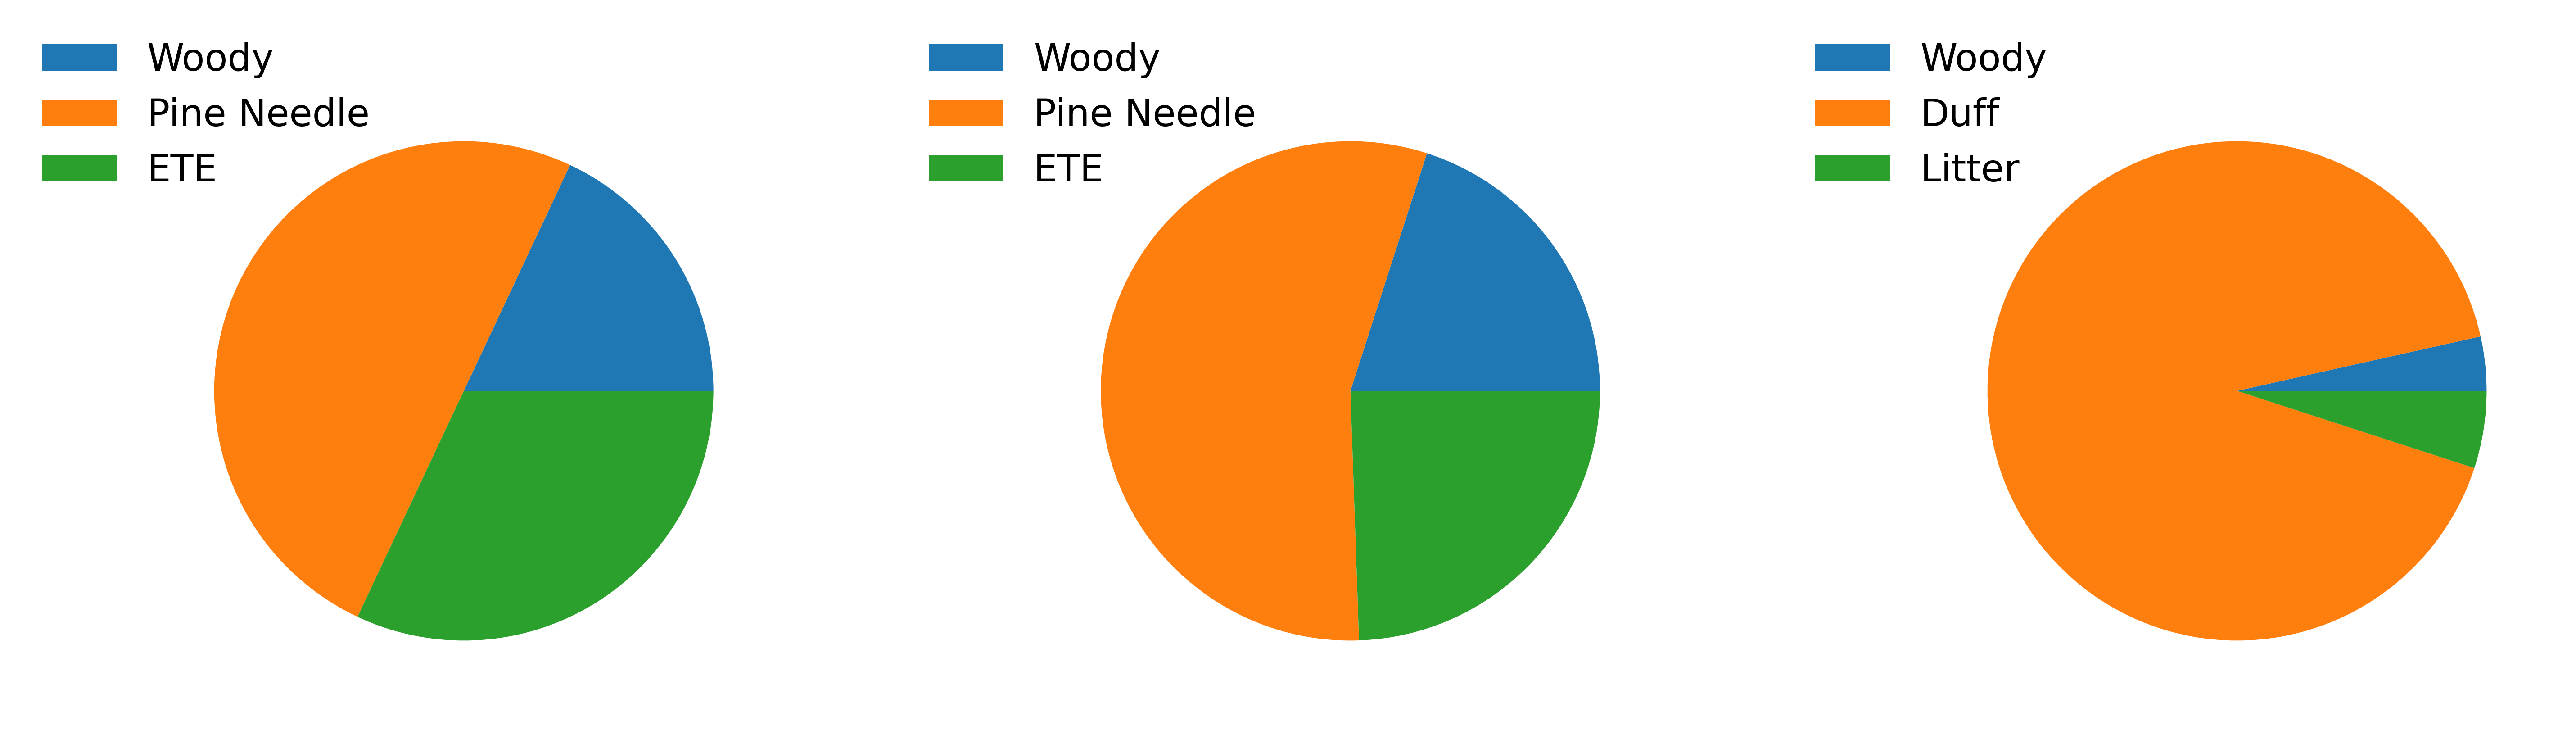

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
patches, texts = ax[0].pie([0.18,0.5,0.32])
ax[0].legend(patches, ['Woody','Pine Needle','ETE'], loc=(-0.2,0.8),frameon=False)
patches2, texts2 = ax[1].pie([0.2,0.554,0.244])
ax[1].legend(patches2, ['Woody', 'Pine Needle', 'ETE'], loc=(-0.2,0.8), bbox_to_anchor=(-0.2, 0.8),frameon=False)
patches3, texts3 = ax[2].pie([0.035,0.914,0.05])
ax[2].legend(patches3, ['Woody', 'Duff', 'Litter'], loc=(-0.2,0.8), bbox_to_anchor=(-0.2, 0.8),frameon=False)
###figure 1 
fig.savefig('1.png')

In [4]:
import seaborn as sns

In [5]:
import pandas as pd

def reshape_csv(csv_path: str) -> pd.DataFrame:
    """
    Reshapes the CSV file specified by the given path to have "Wavelength (nm)" as the index and various time points as columns.
    Each cell in the reshaped DataFrame will contain the corresponding "Abs" (absorbance) value.
    Converts all values to float and the "Wavelength (nm)" index to int after rounding.
    
    Args:
    - csv_path (str): The path to the input CSV file.
    
    Returns:
    - pd.DataFrame: The reshaped and converted DataFrame.
    """
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Drop the first row with redundant labels
    df = df.drop(0)
    
    # Using a dictionary to store reshaped data
    reshaped_data = {'Wavelength (nm)': df.iloc[:, 0].values}
    
    # Iterating through pairs of columns and reshaping
    for i in range(0, df.shape[1], 2):
        time_point = df.columns[i]
        if 'Unnamed' not in time_point:
            # Extract the numeric value from the time_point and use it as the key for reshaped_data
            num_minutes = int(''.join(filter(str.isdigit, time_point)))
            reshaped_data[num_minutes] = df.iloc[:, i+1].values

    # Convert the dictionary to a DataFrame
    reshaped_df = pd.DataFrame(reshaped_data)
    reshaped_df = reshaped_df.set_index('Wavelength (nm)')
    
    # Drop rows containing NaN values
    reshaped_df.dropna(axis=0, inplace=True)
    
    # Convert data types
    # Convert all columns to float
    reshaped_df = reshaped_df.astype(float)
    
    # Convert the index (Wavelength) to int after rounding
    rounded_index = pd.Series(reshaped_df.index).astype(float).round().astype(int)
    reshaped_df.index = rounded_index
    
    return reshaped_df


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum_progression(df: pd.DataFrame):
    """
    Plots the spectrum progression in time. 
    Time progression is plotted as a color gradient between black and red.
    
    Args:
    - df (pd.DataFrame): DataFrame with "Wavelength (nm)" as the index and time points as columns.
    
    Returns:
    - None
    """
    
    # Exclude the BLANK column
    if 'BLANK' in df.columns:
        df = df.drop(columns=['BLANK'])
    
    # Define a color map from black to red based on the number of time points
    cmap = plt.get_cmap('Reds')
    colors = cmap(np.linspace(0.1, 1, len(df.columns)))
    plt.figure()
    # Plot each time series with the corresponding color
    for idx, col in enumerate(df.columns):
        plt.plot(df.index, df[col], label=col, color=colors[idx])
    
    # Add a color bar to indicate time progression
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                               norm=plt.Normalize(vmin=0, vmax=len(df.columns)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, len(df.columns), 6))
    cbar.set_label('Time Progression', rotation=270, labelpad=20)
    
    # Other plot adjustments
    plt.title('Spectrum Progression in Time')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')

    #plt.legend(loc='upper right', ncol=2, fontsize='small', title='Time Points')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Test the function with the refactored DataFrame


In [7]:
def plot_abs_change_at_wavelengths(df: pd.DataFrame, wavelengths: list):
    """
    Plots the absorbance change over time at specified wavelengths.
    
    Args:
    - df (pd.DataFrame): DataFrame with "Wavelength (nm)" as the index and time points as columns.
    - wavelengths (list): List of wavelengths at which absorbance change should be plotted.
    
    Returns:
    - None
    """
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for wavelength in wavelengths:
        if wavelength in df.index:
            ax.plot(df.columns, df.loc[wavelength]/df.loc[wavelength][0], label=f'{wavelength} nm')
    
    # Plot adjustments
    plt.figure()
    ax.set_title('Absorbance Change Over Time at Specified Wavelengths')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Absorbance')
    ax.legend(loc='upper right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
def AAE_progression(df):
    df_log_log = df.copy()
    df_log_log = df_log_log[(df_log_log.index<=480)&(df_log_log.index>=280)]
    df_log_log.reset_index(inplace=True)
    df_log_log =  np.log(df_log_log)
    AAE = []
    AAE_error = []
    Time = []
    R2 = []
    for (columnName, columnData) in df_log_log.items():
        if columnName == 'Wavelength (nm)' or  columnName == 'Blank' :
            pass
        else:
            x = df_log_log['Wavelength (nm)']
            y = columnData
            Time.append(int(columnName))
            slope,intercept = np.polyfit(x=x,y=y,deg=1)
            AAE.append(-1*slope)
            y_pred = slope * x + intercept
            # Calculate the residuals
            residuals = y - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - (ss_res / ss_tot)
            R2.append(r2)
            std_error = np.std(residuals, ddof=2)
            # Calculate the standard error of the slope
            slope_std_error = std_error / np.sqrt(np.sum((x - np.mean(x))**2))

            AAE_error.append(slope_std_error)
    plt.figure()
    plt.plot(Time,AAE)
    plt.errorbar(Time,AAE,AAE_error,fmt='o')
    plt.title('AAE Progression with 300nm Aquesous Photoylsis')
    plt.xlabel('Time (min)')
    plt.ylabel('AAE')
    return Time ,AAE, AAE_error,R2

In [9]:
def mac_progression(df):
    corr = df[(df.index>=680)&(df.index<=700)].mean()
    #print(corr)
    vis = df[(df.index>280)&(df.index<=400)]
    vis = vis -corr
    uv =  df[(df.index>=280)&(df.index<=400)]
    uv = uv -corr
    plt.figure()
    plt.plot(vis.sum(axis=0)/vis.sum(axis=0)[0],label='Visable')
    #plt.plot(vis.sum(axis=0),label='Visable')
    #plt.plot(uv.sum(axis=0),label='UV')

    plt.plot(uv.sum(axis=0)/uv.sum(axis=0)[0],label='UV')
    plt.title('ABS Progression with 300nm Aquesous Photoylsis (not normalize yet)')
    plt.xlabel('Time (min)')
    plt.ylabel('ABS')
    plt.legend()

In [10]:
df_P_dry = reshape_csv('1101_2H.csv')
df_P_wet = reshape_csv('1028_2H.csv')

df_CP_dry = reshape_csv('1102_2H.csv')
df_CP_wet = reshape_csv('1106_2H.csv')

df_BR_dry = reshape_csv('1109_2H.csv')
df_BR_wet = reshape_csv('1115_2H.csv')

In [11]:
df_BR_dry_beaker = reshape_csv('1114_beaker.csv')

In [15]:
df_P_dry.to_csv('P_dry_clean.csv')

df_P_wet.to_csv('P_wet_clean.csv')

df_CP_dry.to_csv('CP_dry_clean.csv')
df_CP_wet.to_csv('CP_wet_clean.csv')

df_BR_dry.to_csv('BR_dry_clean.csv')
df_BR_wet.to_csv('BR_wet_clean.csv')

In [12]:
#### this is the OC measurement result
### in ug/cm2
OC_raw = [1.98,3.33,2.29,3.45,4.80,3.35,5.41]
err_oc_raw = [0.2,0.27,0.21,0.27,0.34,0.27,0.37]
###1.5cm2 filter, 0.1mL, ----> g/cm3 
OC_conc = np.asarray(OC_raw) * 1.5 * 1e-6/ 0.1 
print(OC_conc)
err_oc_conc = np.asarray(err_oc_raw) * 1.5* 1e-6 / 0.1 
print(err_oc_conc)
### convert to log e version 
MAC_conv =OC_conc / np.log (10)
MAC_err_conv =OC_conc / np.log (10)


[2.970e-05 4.995e-05 3.435e-05 5.175e-05 7.200e-05 5.025e-05 8.115e-05]
[3.00e-06 4.05e-06 3.15e-06 4.05e-06 5.10e-06 4.05e-06 5.55e-06]


In [33]:
print(OC_conc*1e6)
print(err_oc_conc*1e6)

[29.7  49.95 34.35 51.75 72.   50.25 81.15]
[3.   4.05 3.15 4.05 5.1  4.05 5.55]


In [34]:
###g/cm3  --> g/m3 -- ug/m3
OC_conc *1e3*1e6

array([29700., 49950., 34350., 51750., 72000., 50250., 81150.])

In [13]:
#import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def mac_progression(df, main_ax,txt,legend=False):
    # Create inset_axes in the upper right corner, with separate x,y axis
    axins = inset_axes(main_ax, width="35%", height="35%", loc=1)  # 1: upper right corner
    #axins = inset_axes(main_ax, width="40%", height="40%", loc=1)  # for the BR vs BR chart
    

    vis = df[(df.index > 400) & (df.index <= 500)]

    uv = df[(df.index >= 280) & (df.index <= 400)]

    # For visible
    
    vis_data = vis.sum(axis=0) / vis.sum(axis=0)[0]
    uv_data = uv.sum(axis=0) / uv.sum(axis=0)[0]

    #axis
    axins.annotate(txt,xy=(0, 1.2), xycoords="axes fraction", 
               xytext=(10, -10), textcoords="offset points", 
               ha="left", va="top",)
    axins.plot(vis_data,  color='red',marker='x',label='Vis')
    #axins.scatter(vis_data.index, vis_data.values, color='red', s=15,marker='x',label='Vis')  # scatter plot for visible

    axins.plot(uv_data,  color='blue',marker='x',label='UV')
    #axins.scatter(uv_data.index, uv_data.values, color='blue', s=15,marker='x',label='UV')  # scatter plot for UV
    if legend:
        axins.legend(loc=(0.6,0.8), fontsize='x-small',frameon=False)
        #axins.legend(loc='center right', fontsize='x-small',frameon=False) ##for Br vs BR

    axins.set_xlabel('Time (min)', fontsize='small')
    axins.set_ylabel('Normlized Abs', fontsize='small')
    axins.tick_params(axis='both', which='both')
    axins.set_ylim((0.6,1.5))
    #axins.set_ylim((,1))

    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)

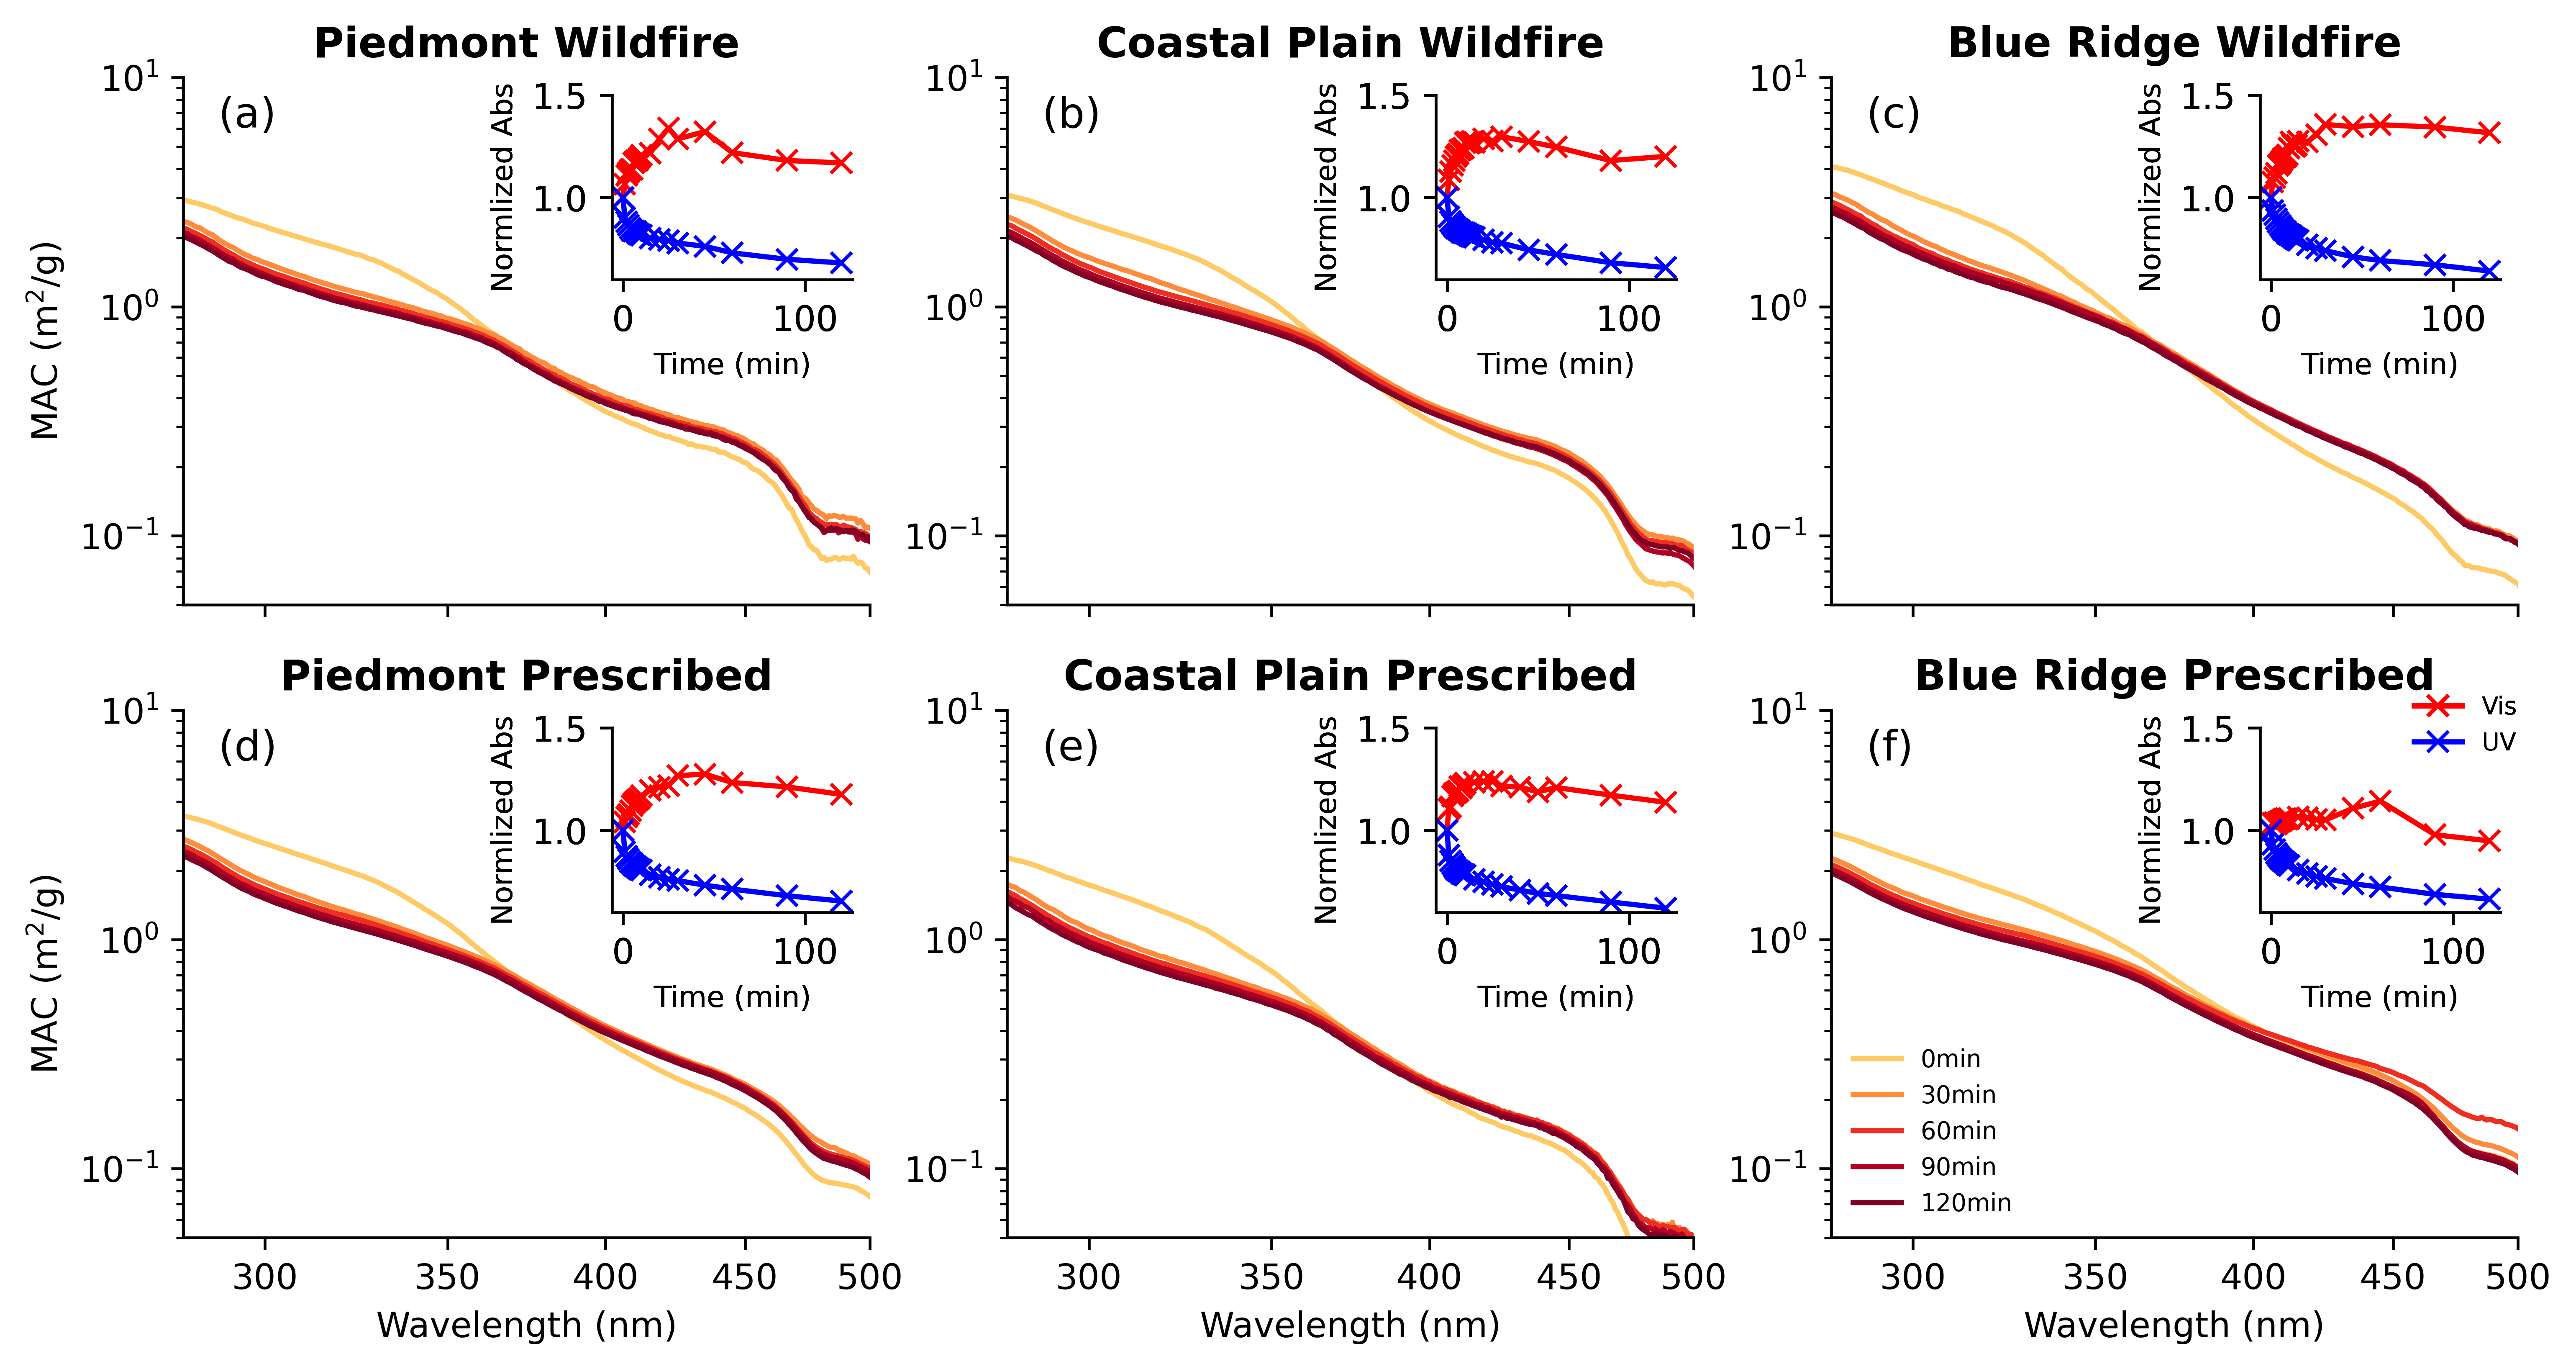

In [14]:
import matplotlib
####for the semi-log graph 
fig, ax = plt.subplots(2, 3, figsize=(12, 6),sharex=True)
col_list = [0, 30, 60, 90, 120]
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.3, 1.1, len(col_list)))

for idx, col in enumerate(col_list):
    ax[0][0].plot(df_P_dry.index, 1e-4*df_P_dry[col]/MAC_conv[0], label=str(col)+'min', color=colors[idx])
    #ax[0][0].plot(df_P_dry.index, df_P_dry[col], label=str(col)+'min', color=colors[idx])
    
    mac_progression(df_P_dry, ax[0][0],txt='')
    
    ax[1][0].plot(df_P_wet.index, 1e-4*df_P_wet[col]/MAC_conv[1], label=str(col)+'min', color=colors[idx])
    #ax[1][0].plot(df_P_wet.index, df_P_dry[col], label=str(col)+'min', color=colors[idx])
    
    mac_progression(df_P_wet, ax[1][0],txt='')

    ax[0][1].plot(df_CP_dry.index, 1e-4*df_CP_dry[col]/MAC_conv[2], label=str(col)+'min', color=colors[idx])
    #ax[0][1].plot(df_CP_dry.index, df_CP_dry[col], label=str(col)+'min', color=colors[idx])
    
    mac_progression(df_CP_dry, ax[0][1],txt='')

    ax[1][1].plot(df_CP_wet.index, 1e-4*df_CP_wet[col]/MAC_conv[3], label=str(col)+'min', color=colors[idx])
    #ax[1][1].plot(df_CP_wet.index, df_CP_wet[col], label=str(col)+'min', color=colors[idx])
    mac_progression(df_CP_wet, ax[1][1],txt='')

    ax[0][2].plot(df_BR_dry.index, 1e-4*df_BR_dry[col]/MAC_conv[4], label=str(col)+'min', color=colors[idx])
    #ax[0][2].plot(df_BR_dry.index, df_BR_dry[col], label=str(col)+'min', color=colors[idx])
    mac_progression(df_BR_dry, ax[0][2],txt='')

    ax[1][2].plot(df_BR_wet.index, 1e-4*df_BR_wet[col]/MAC_conv[5], label=str(col)+'min', color=colors[idx])
    #ax[1][2].plot(df_BR_wet.index, df_BR_wet[col], label=str(col)+'min', color=colors[idx])
    mac_progression(df_BR_wet, ax[1][2],txt='',legend=True)

for row in ax:
    for a in row:
        a.set_xlim((280, 500))
        #a.set_ylim((1e-4,0.02))
        a.set_xscale('log')
        
        a.set_yscale('log')
        x_min, x_max = a.get_xlim()
        #print(x_min,x_max)
        visible_data = a.lines[0].get_ydata()[np.logical_and(a.lines[0].get_xdata() >= x_min, a.lines[0].get_xdata() <= x_max)]
        #print(visible_data.min(), visible_data.max())
        #a.set_ylim(visible_data.min(), visible_data.max()+2)

        a.set_ylim(0.05,10)
        # Hide top and right spines
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.set_xticks([300,350, 400, 450,500])
        a.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #minor_locator = matplotlib.ticker.LogLocator(base=1, subs=np.linspace(2, 10, 9), numticks=10)
        #a.xaxis.set_minor_locator(minor_locator)
# Call mac_progression for each subplot
ax[0][0].set_ylabel('MAC (m$^{2}$/g)')
ax[1][0].set_ylabel('MAC (m$^{2}$/g)')
ax[1][0].set_xlabel('Wavelength (nm)')
ax[1][1].set_xlabel('Wavelength (nm)')
ax[1][2].set_xlabel('Wavelength (nm)')
ax[1][2].legend(loc='lower left',fontsize='x-small',frameon=False)

annotations = [
    (ax[0][0], "(a)",'Piedmont Wildfire'),
    (ax[1][0], "(d)",'Piedmont Prescribed'),
    (ax[0][1], "(b)","Coastal Plain Wildfire"),
    (ax[1][1], "(e)","Coastal Plain Prescribed"),
    (ax[0][2], "(c)","Blue Ridge Wildfire"),
    (ax[1][2], "(f)","Blue Ridge Prescribed"),
]

for a, text,title in annotations:
    a.set_title(title, weight='bold')
    a.annotate(text, xy=(0, 0.9), xycoords="axes fraction", 
               xytext=(10, +10), textcoords="offset points", 
               ha="left", va="top",fontsize=12)

#ax[0][0].text(250,0.4,"(A) Wildfire",fontsize='large')
#ax[1][0].text(250,0.4,"(B) Prescibed",fontsize='large')

#plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()

fig.savefig('2.png')

In [37]:
def AAE_progression(df):
    df_log_log = df.copy()
    df_log_log = df_log_log[(df_log_log.index<=480)&(df_log_log.index>=280)]
    df_log_log.reset_index(inplace=True)
    df_log_log =  np.log10(df_log_log)
    AAE = []
    AAE_error = []
    Time = []
    R2 = []
    slope_list = []
    intercept_list = []

    for (columnName, columnData) in df_log_log.items():
        if columnName == 'Wavelength (nm)' or  columnName == 'Blank' :
            pass
        else:
            x = df_log_log['Wavelength (nm)']
            y = columnData
            Time.append(int(columnName))
            slope,intercept = np.polyfit(x=x,y=y,deg=1)
            slope_list.append(slope)
            intercept_list.append(intercept)

            AAE.append(-1*slope)
            y_pred = slope * x + intercept
            # Calculate the residuals
            residuals = y - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - (ss_res / ss_tot)
            R2.append(r2)
            std_error = np.std(residuals, ddof=2)
            # Calculate the standard error of the slope
            slope_std_error = std_error / np.sqrt(np.sum((x - np.mean(x))**2))

            AAE_error.append(slope_std_error)
    plt.figure()
    plt.plot(Time,AAE)
    plt.errorbar(Time,AAE,AAE_error,fmt='o')
    plt.title('AAE Progression with 300nm Aquesous Photoylsis')
    plt.xlabel('Time (min)')
    plt.ylabel('AAE')
    return Time ,AAE, AAE_error,R2,(slope_list,intercept_list)



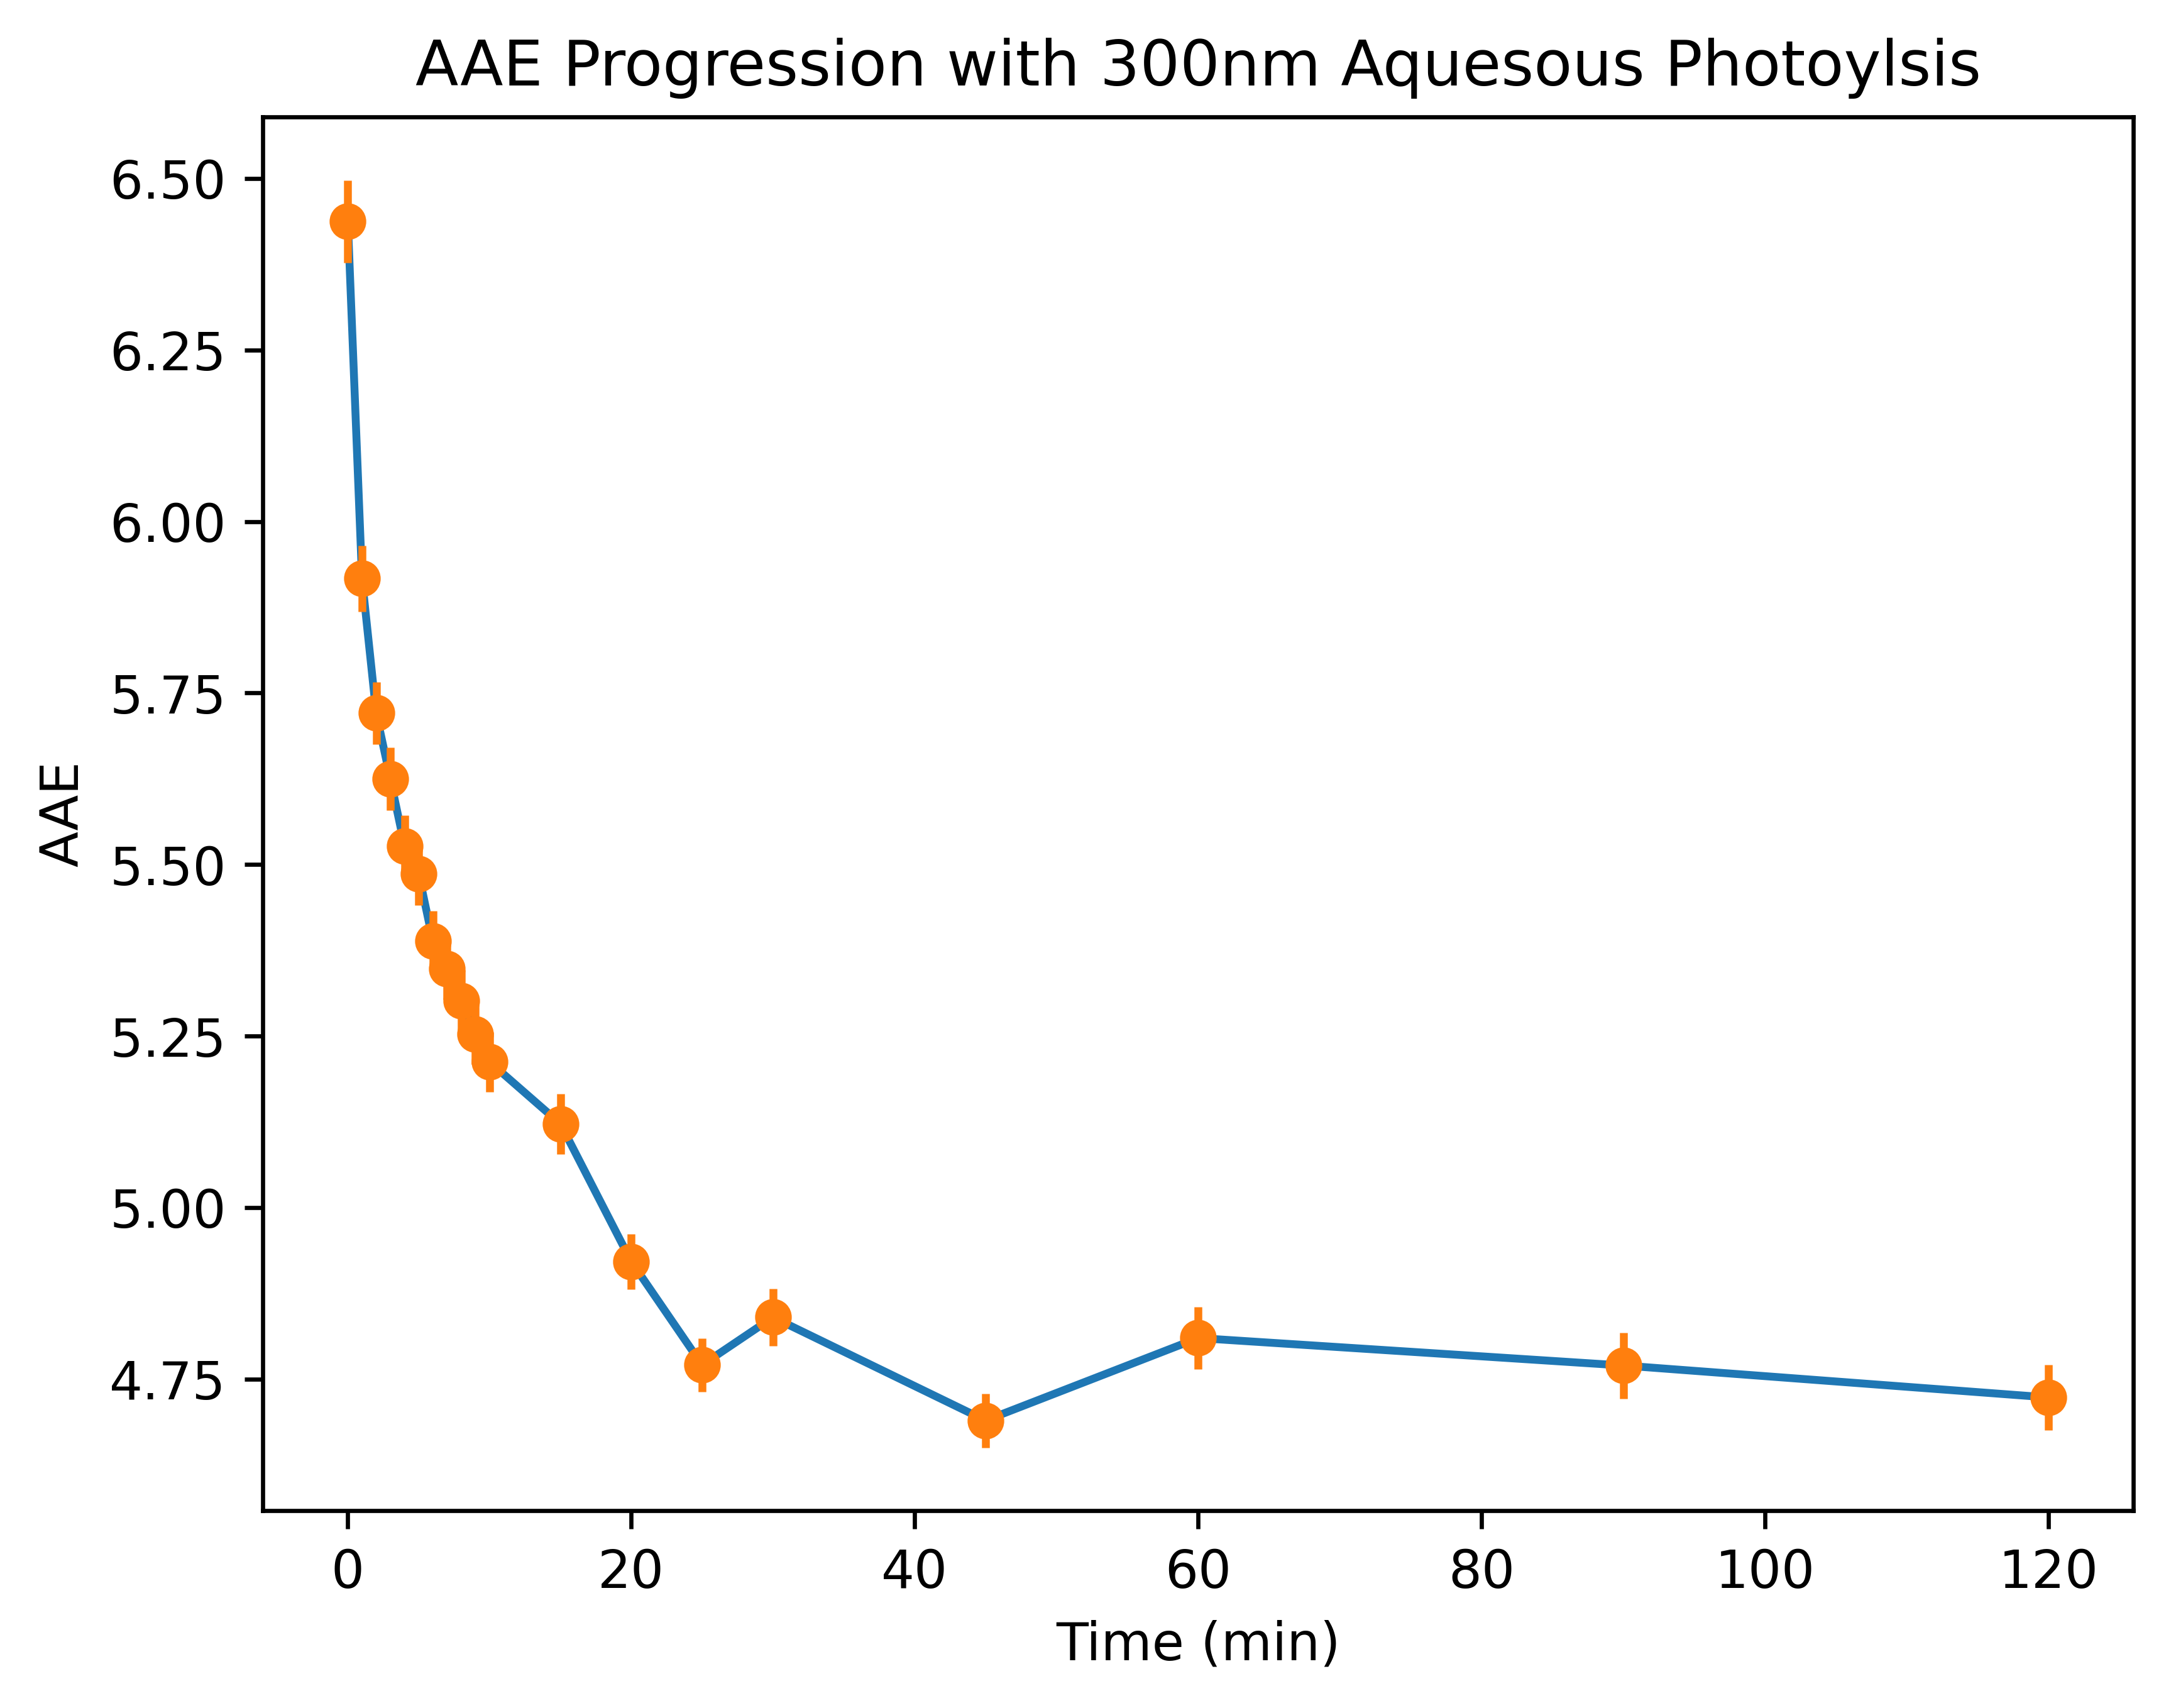

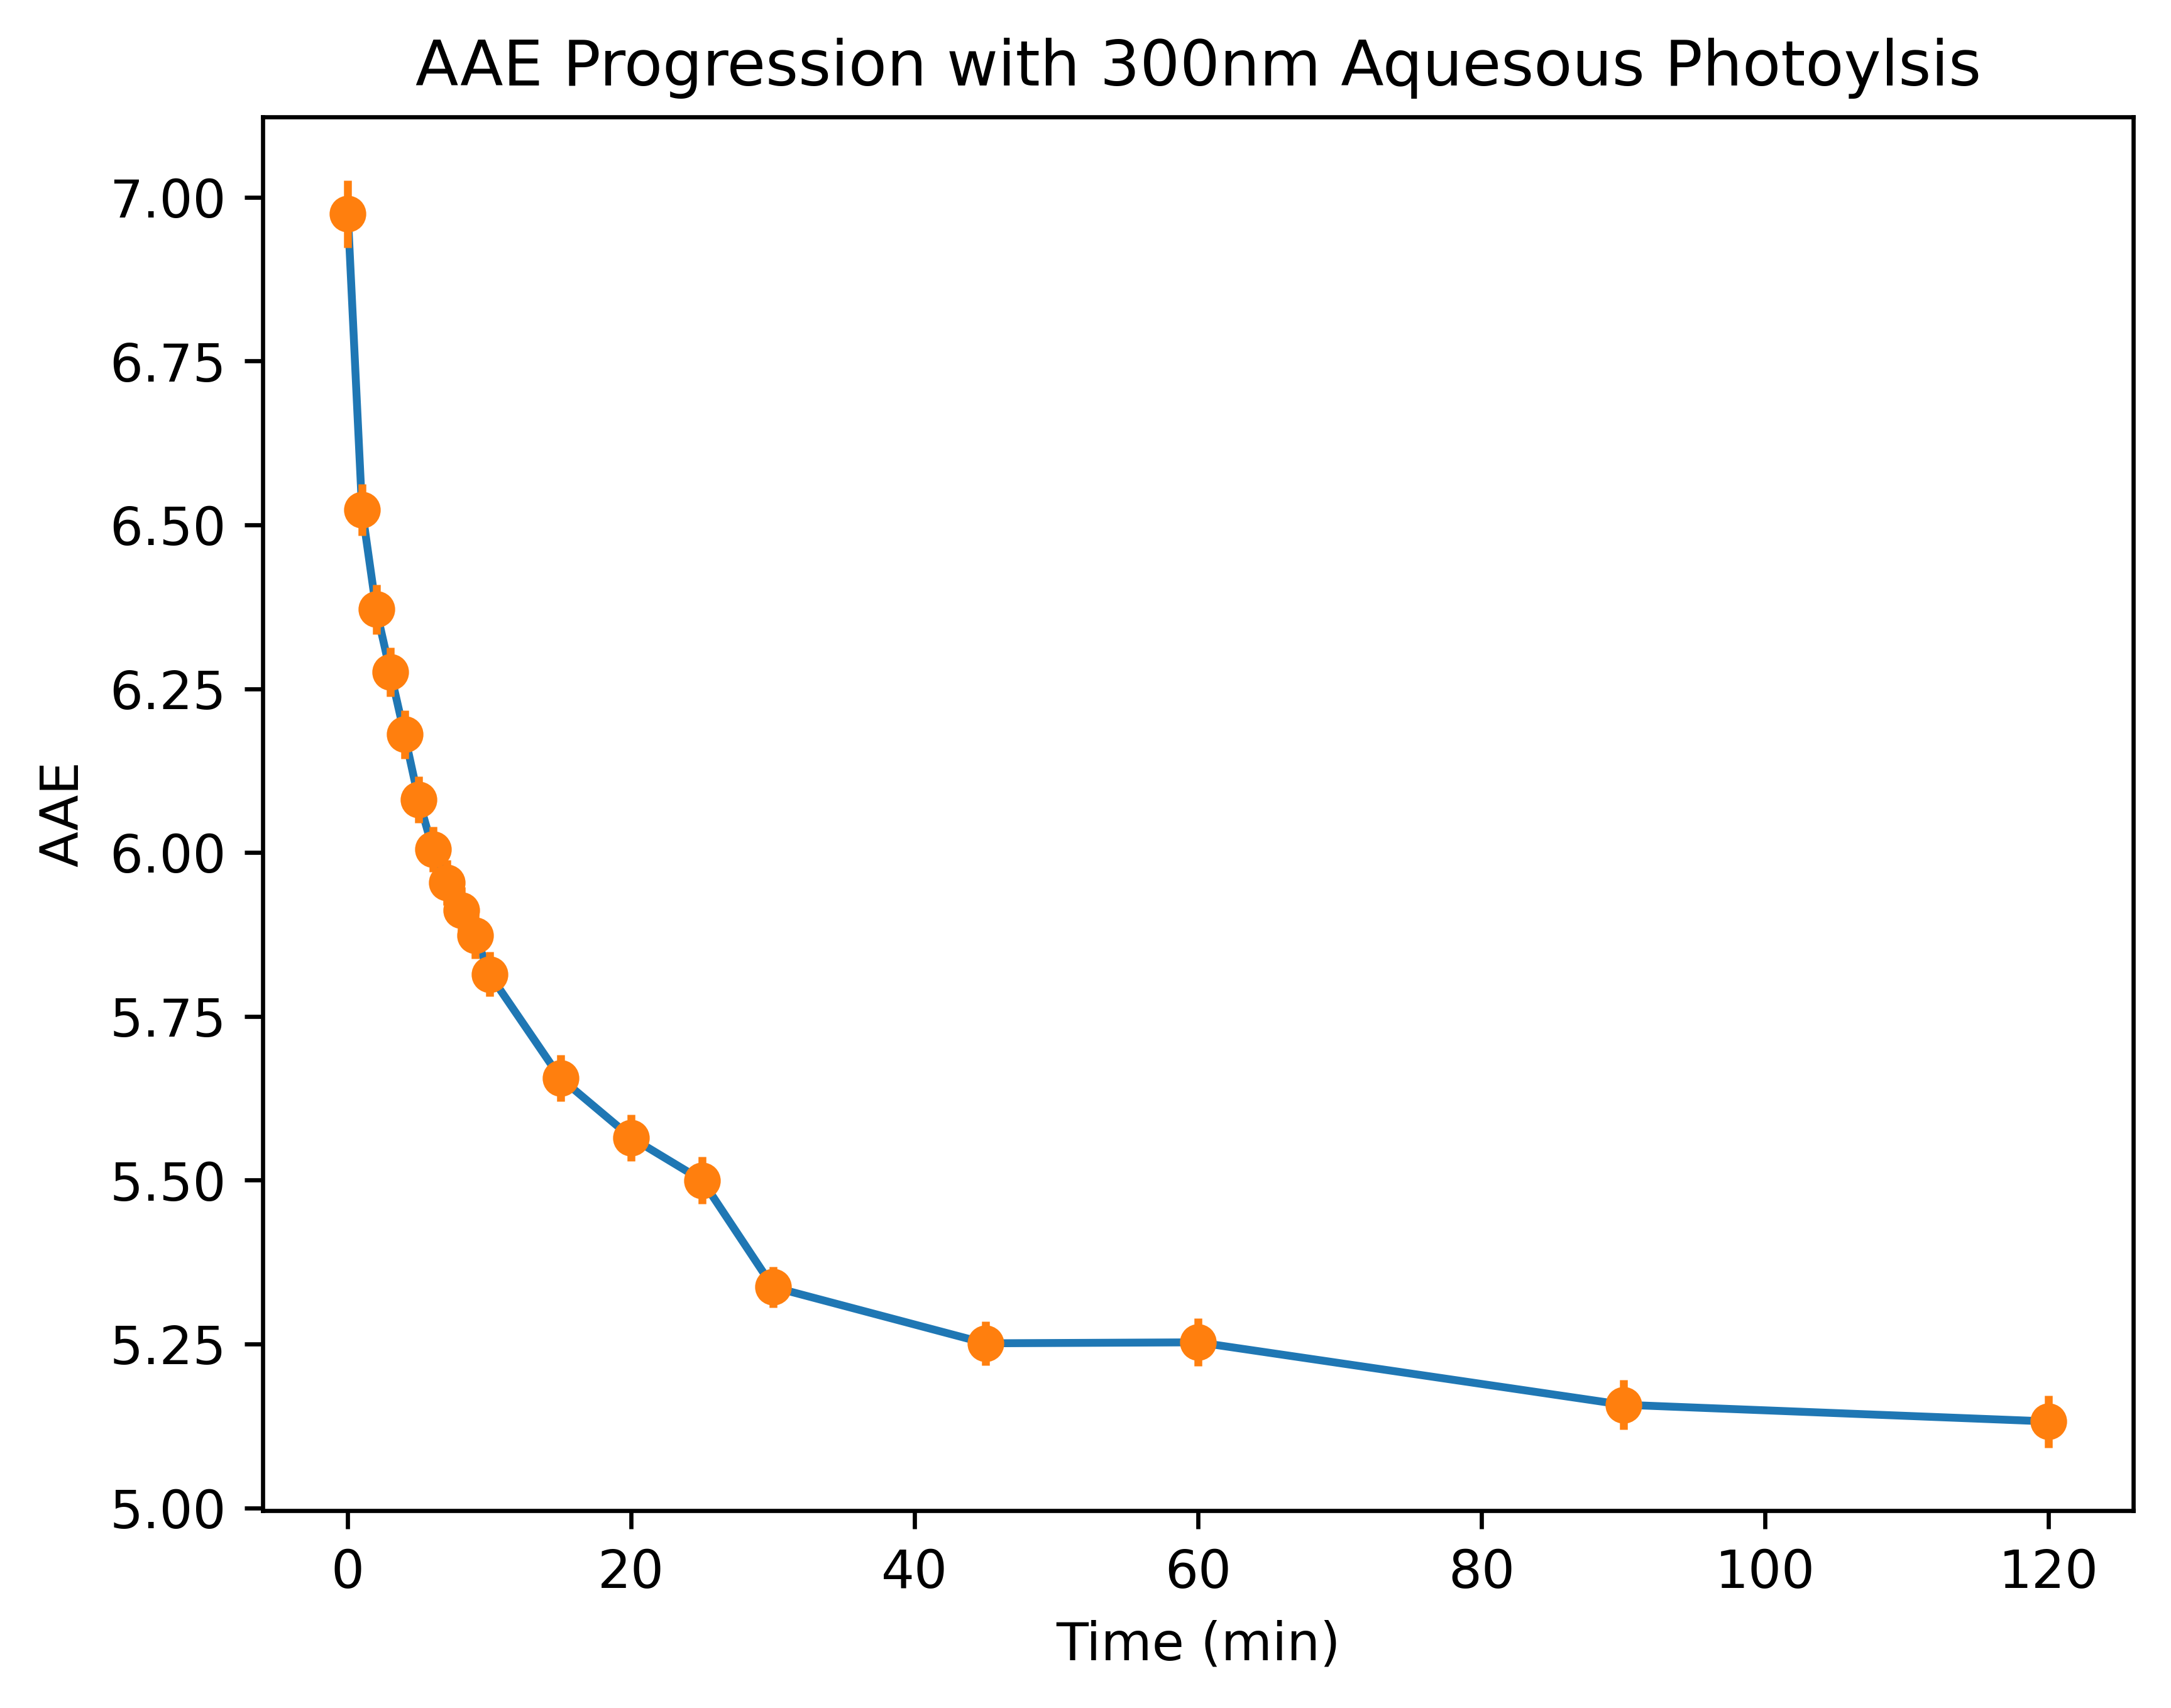

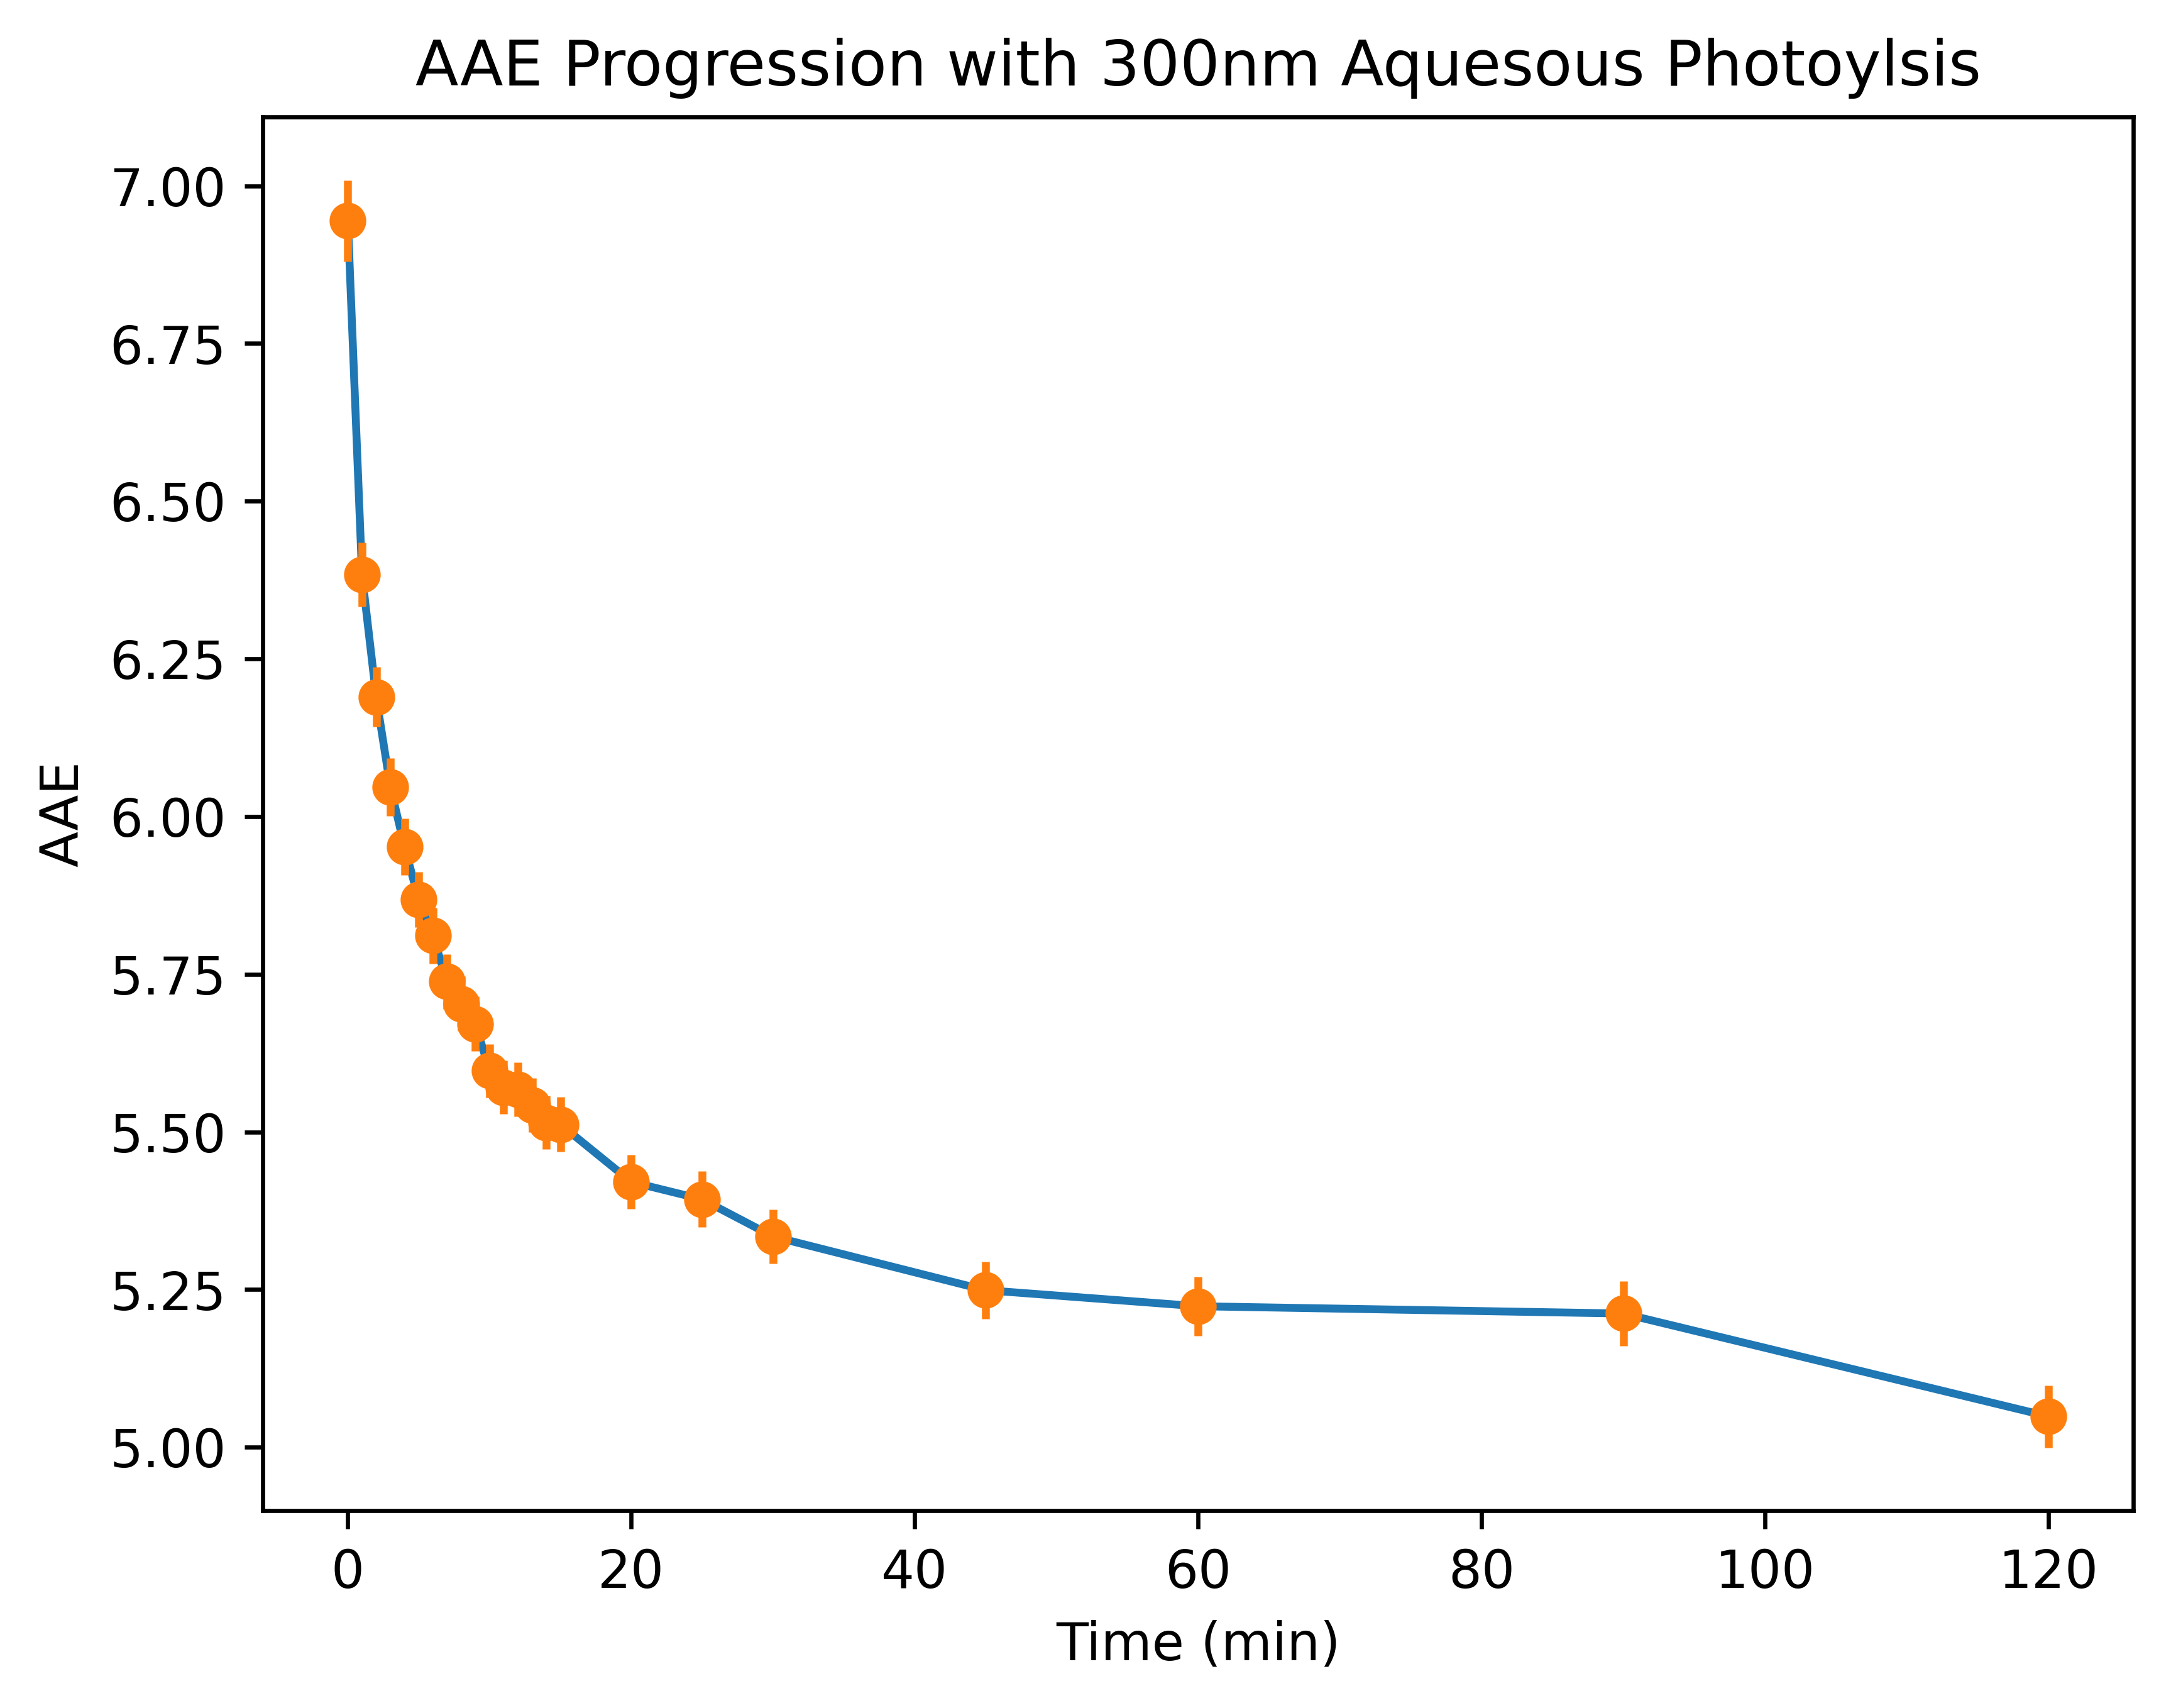

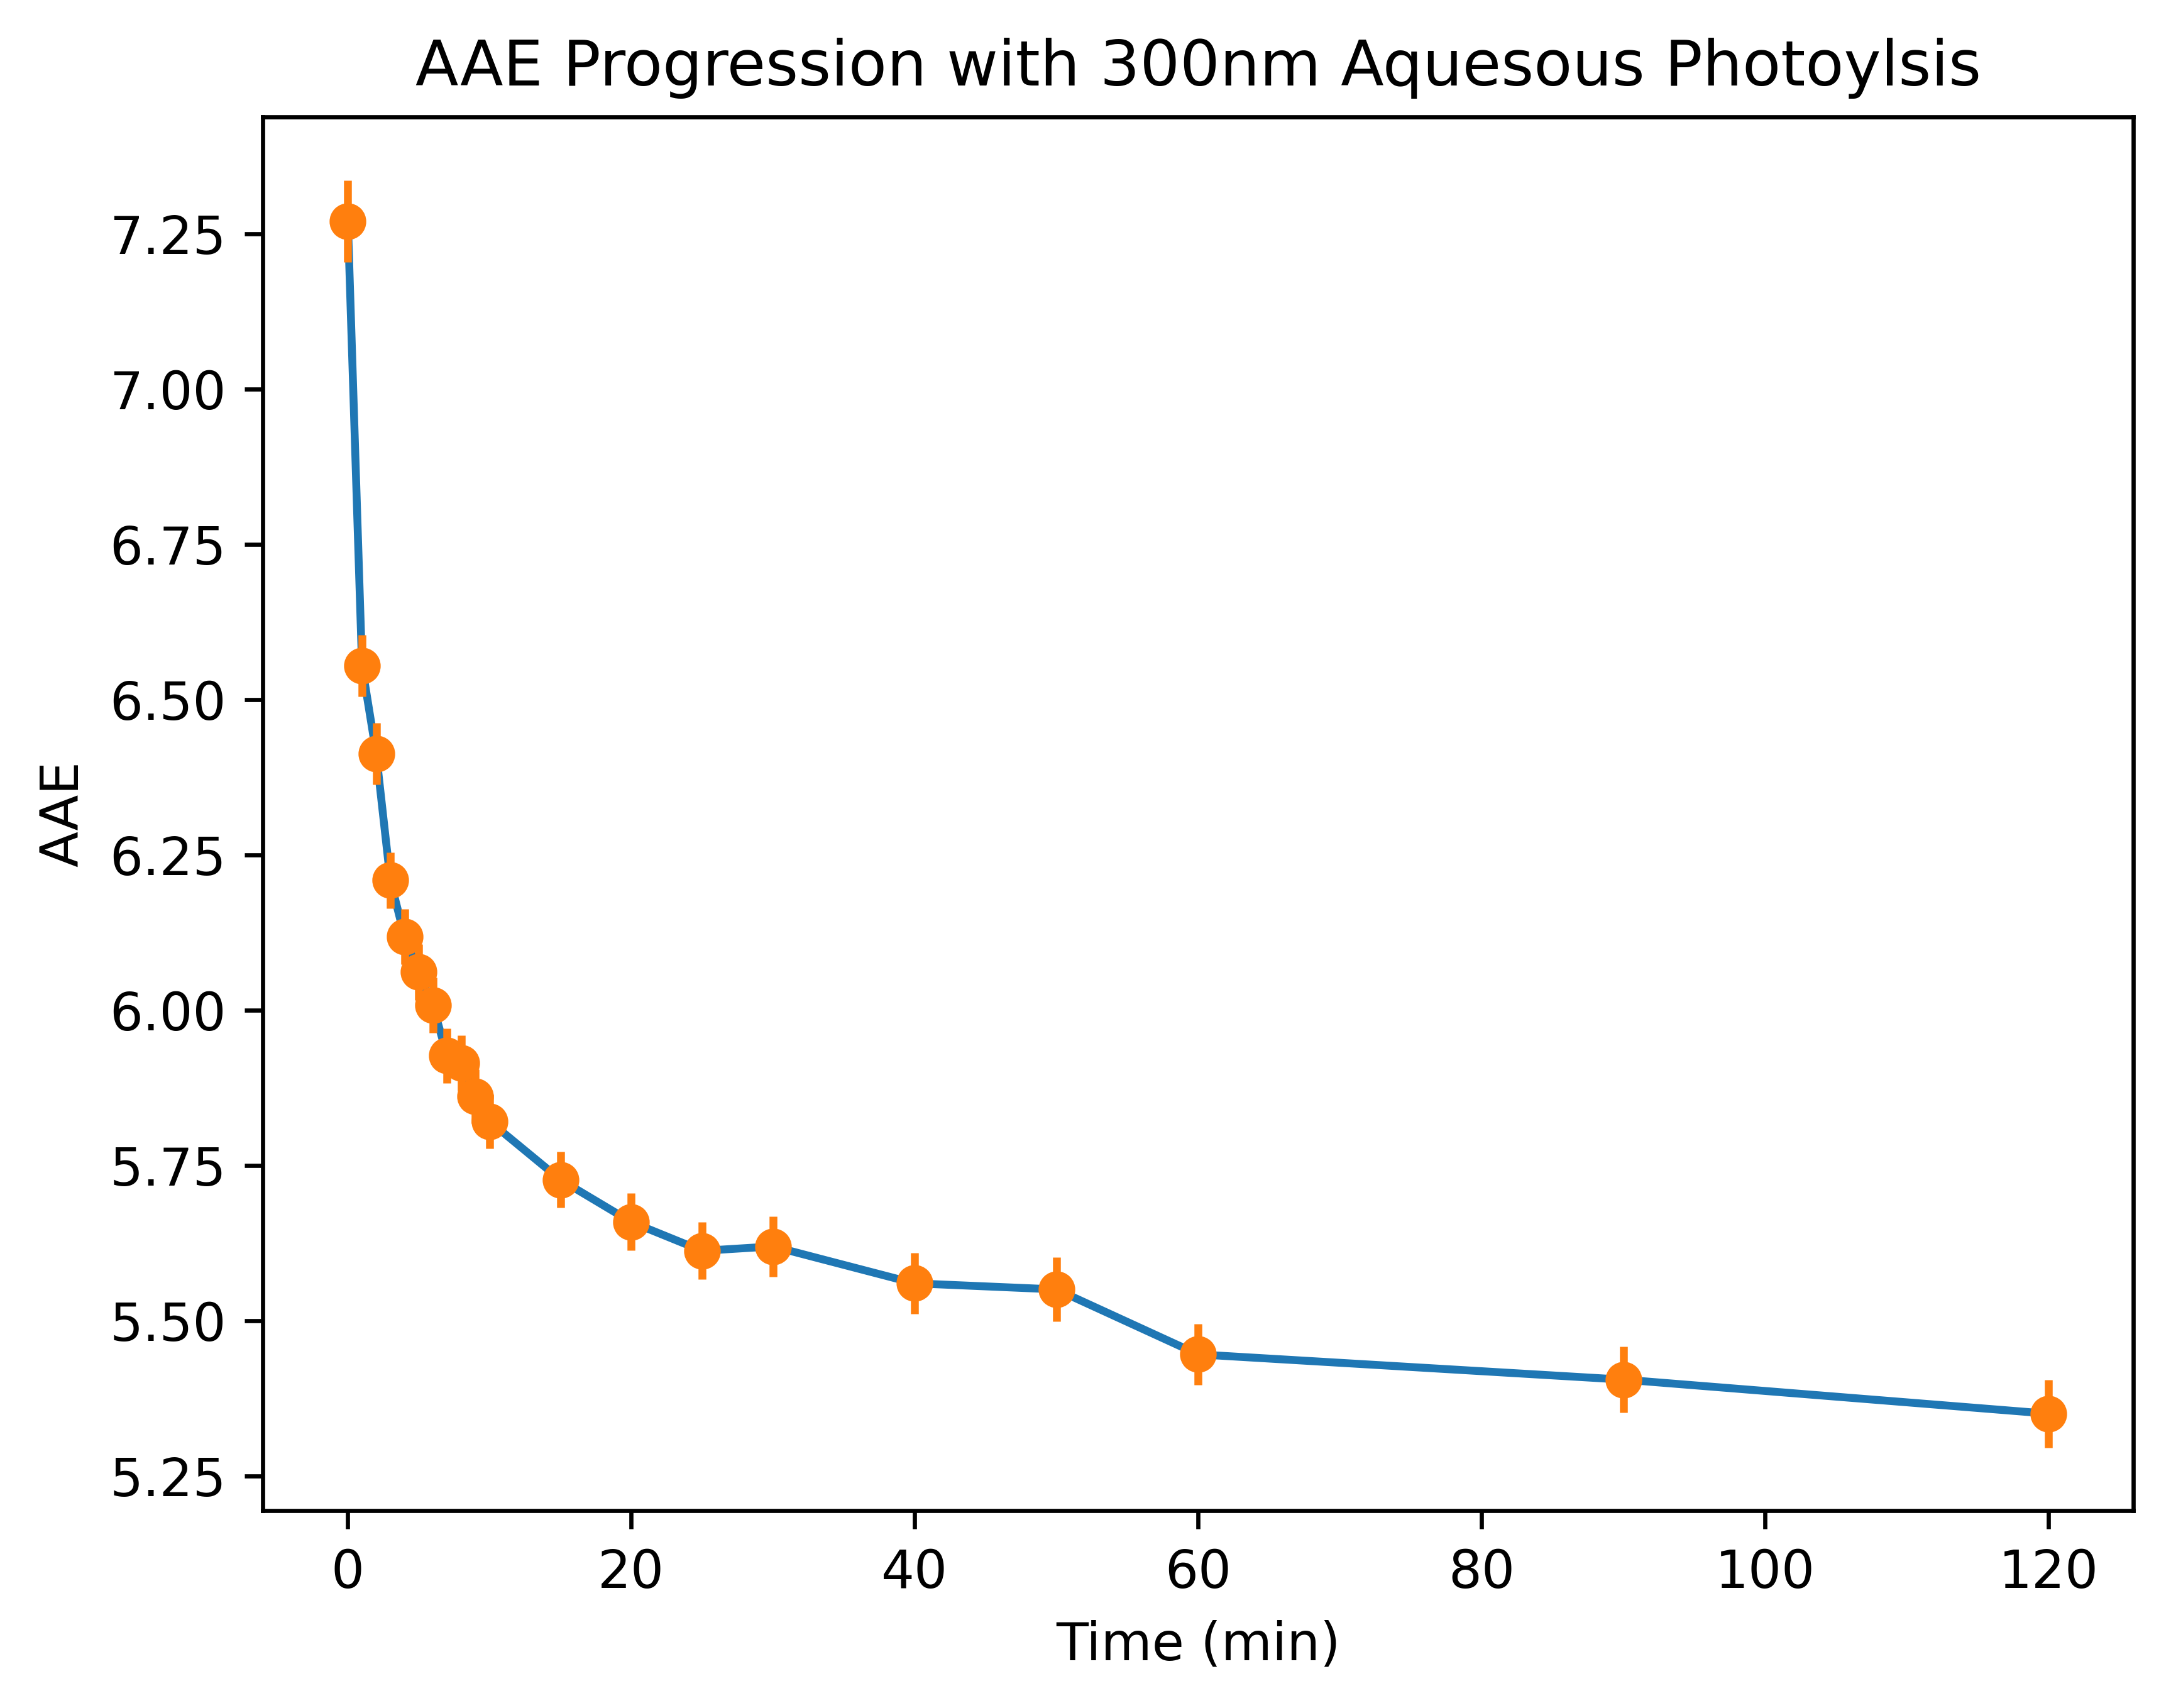

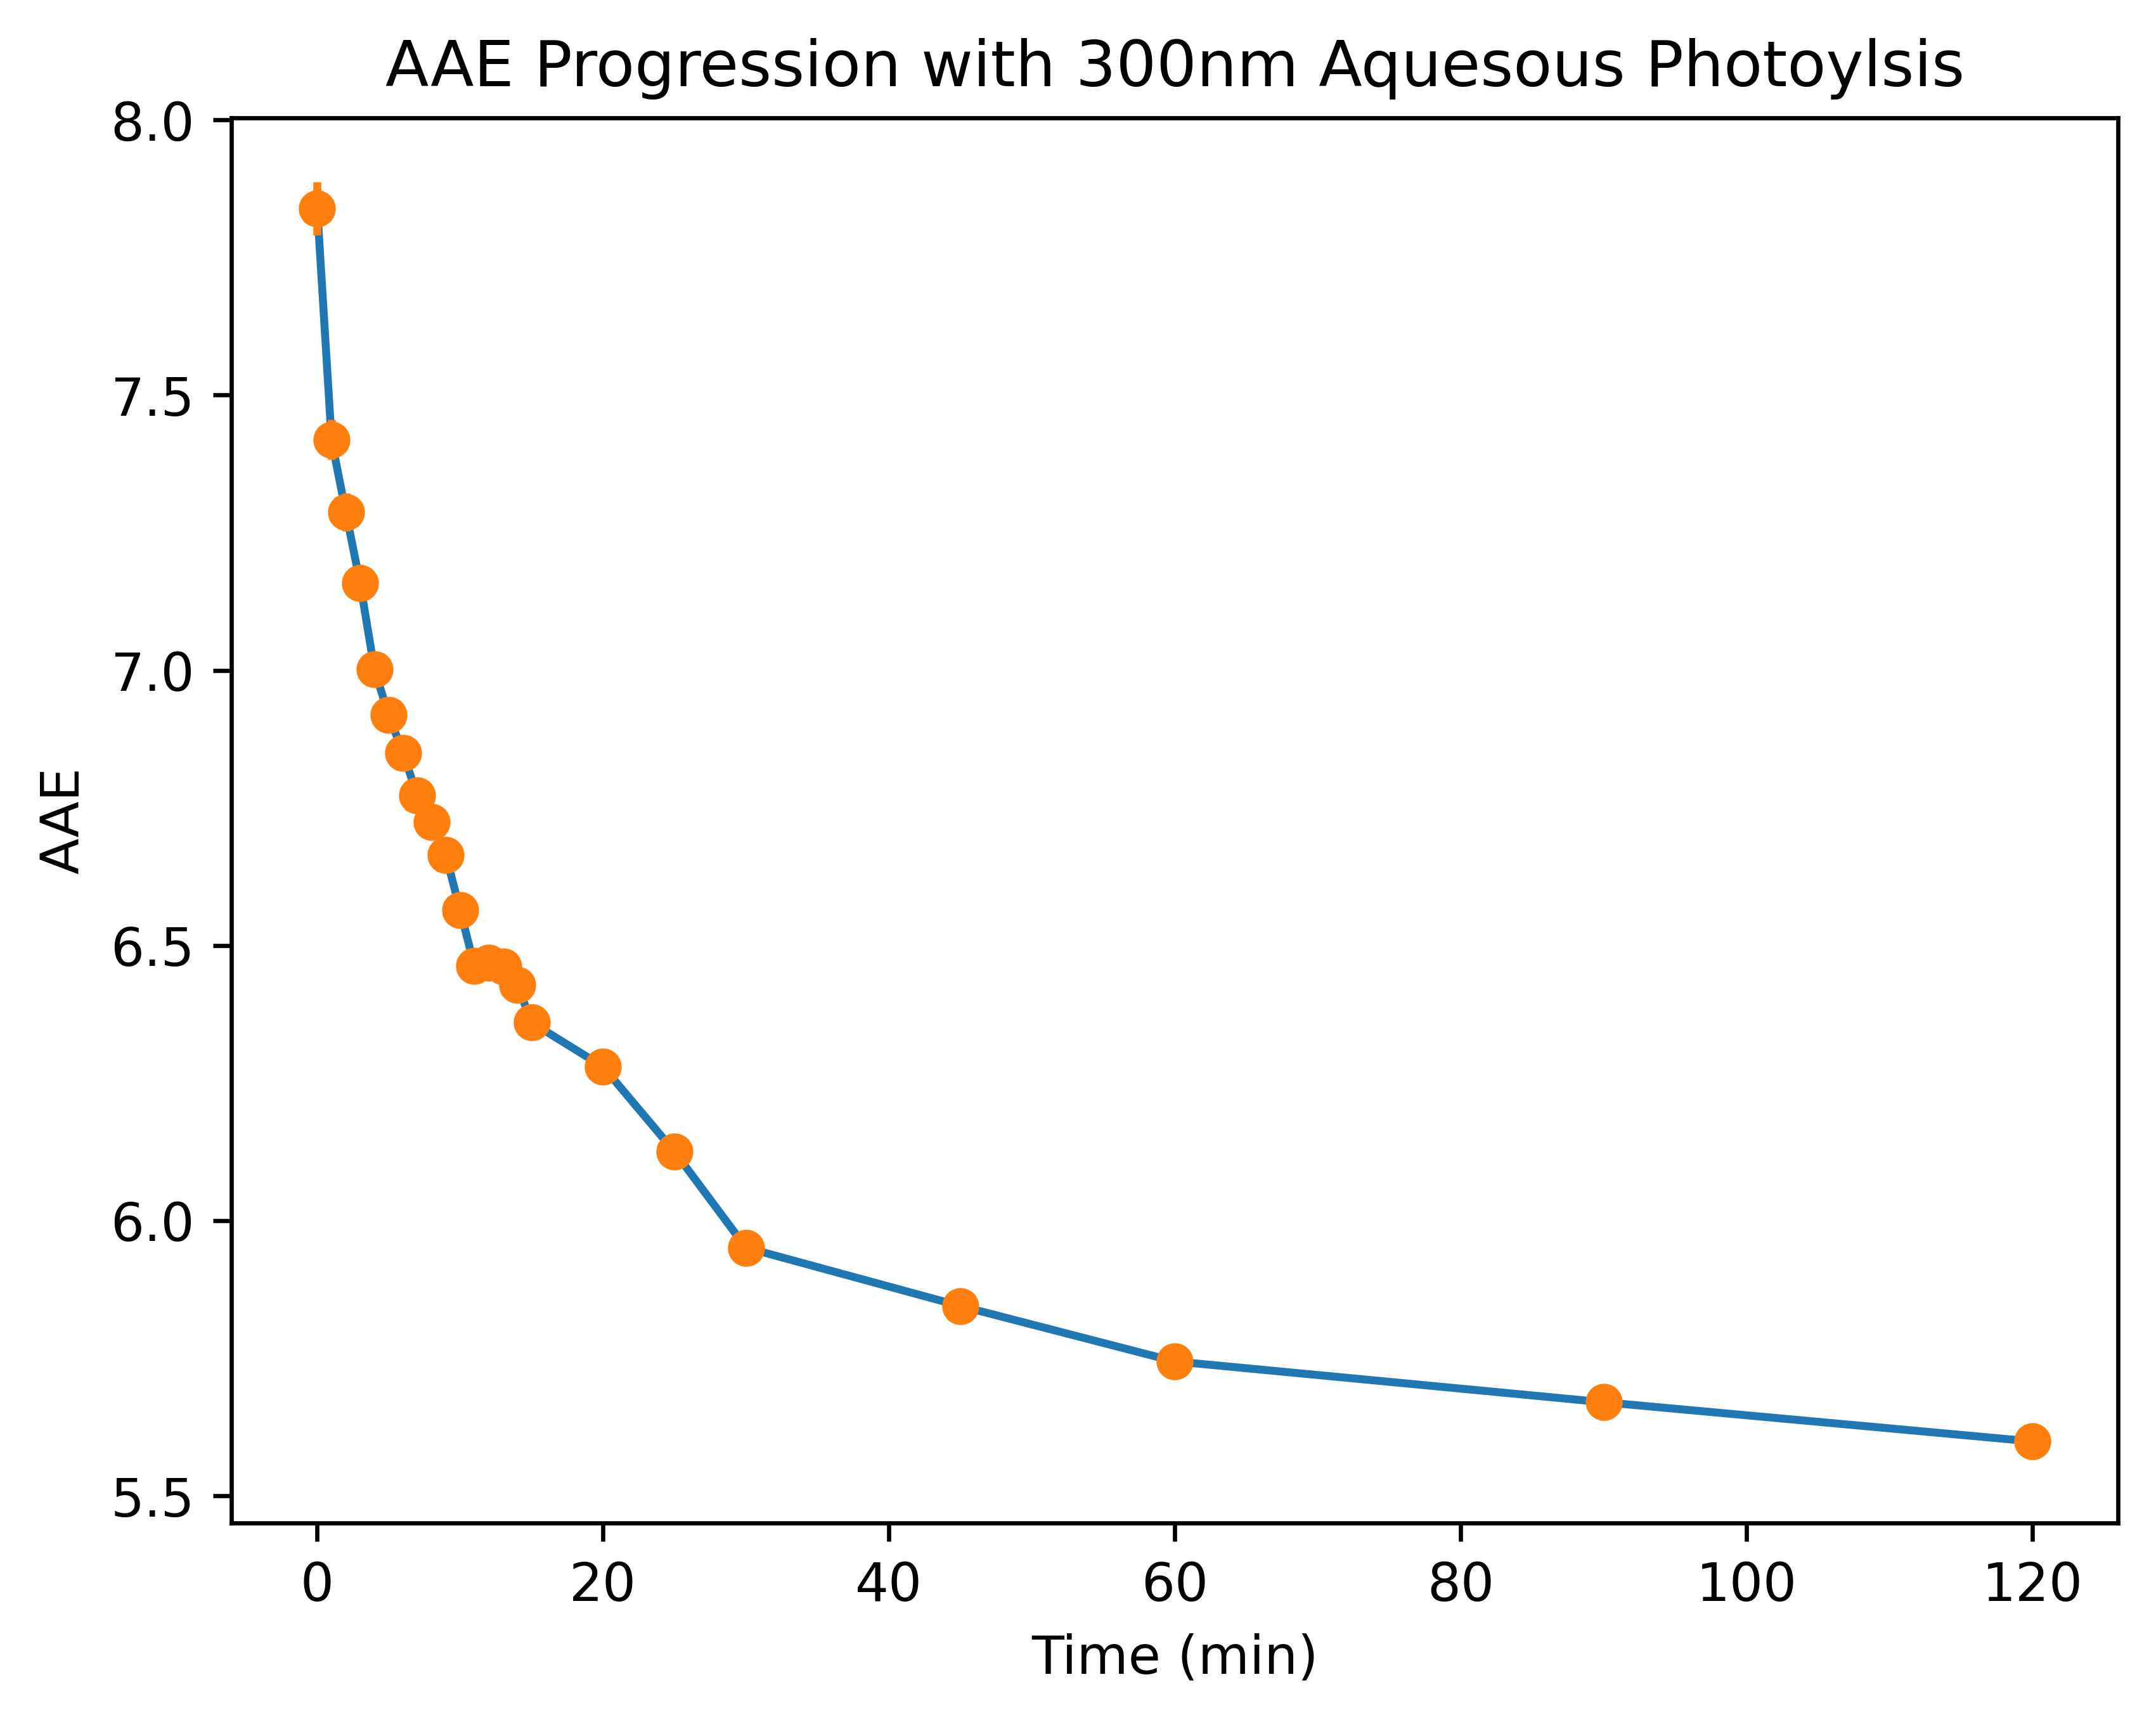

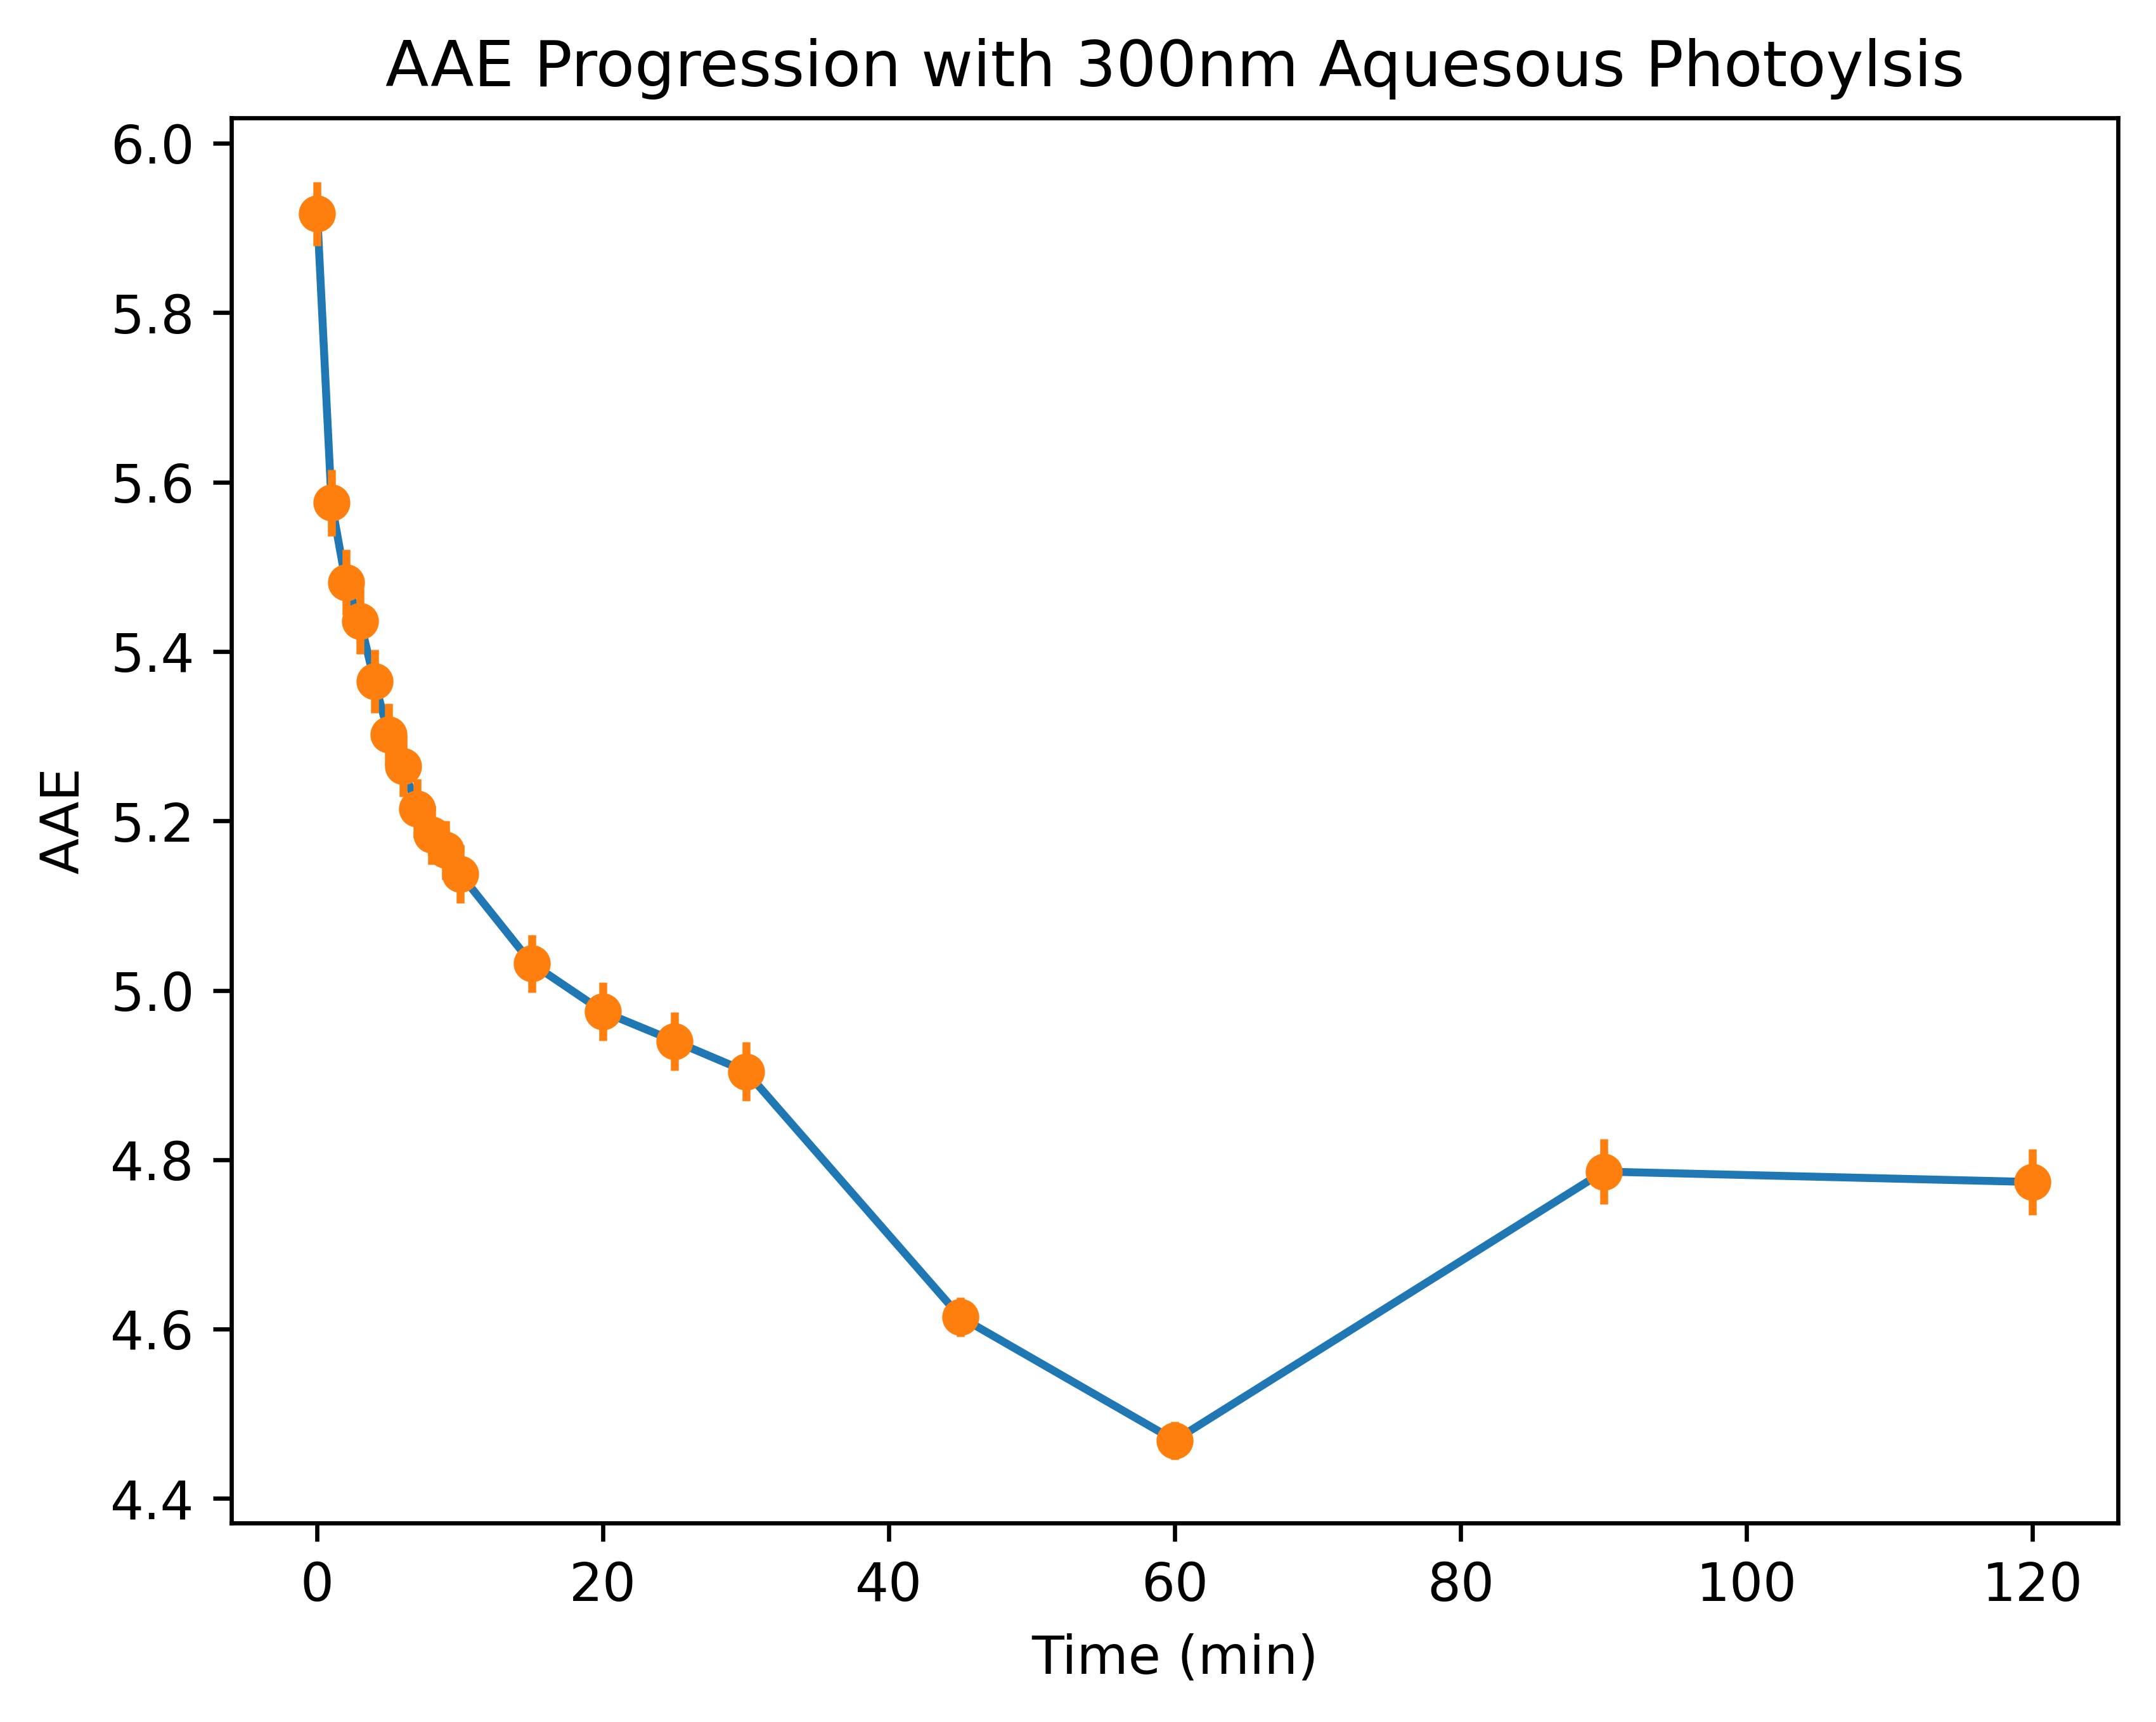

In [38]:
time,AAE_1,err_1,R2_1,fit_1=AAE_progression(df_P_dry )
time,AAE_2,err_2,R2_2,fit_2=AAE_progression(df_P_wet )
time,AAE_3,err_3,R2_3,fit_3=AAE_progression(df_CP_dry )
time,AAE_4,err_4,R2_4,fit_3=AAE_progression(df_CP_wet )
time,AAE_5,err_5,R2_5,fit_4=AAE_progression(df_BR_dry )
time,AAE_6,err_6,R2_6,fit_5=AAE_progression(df_BR_wet )

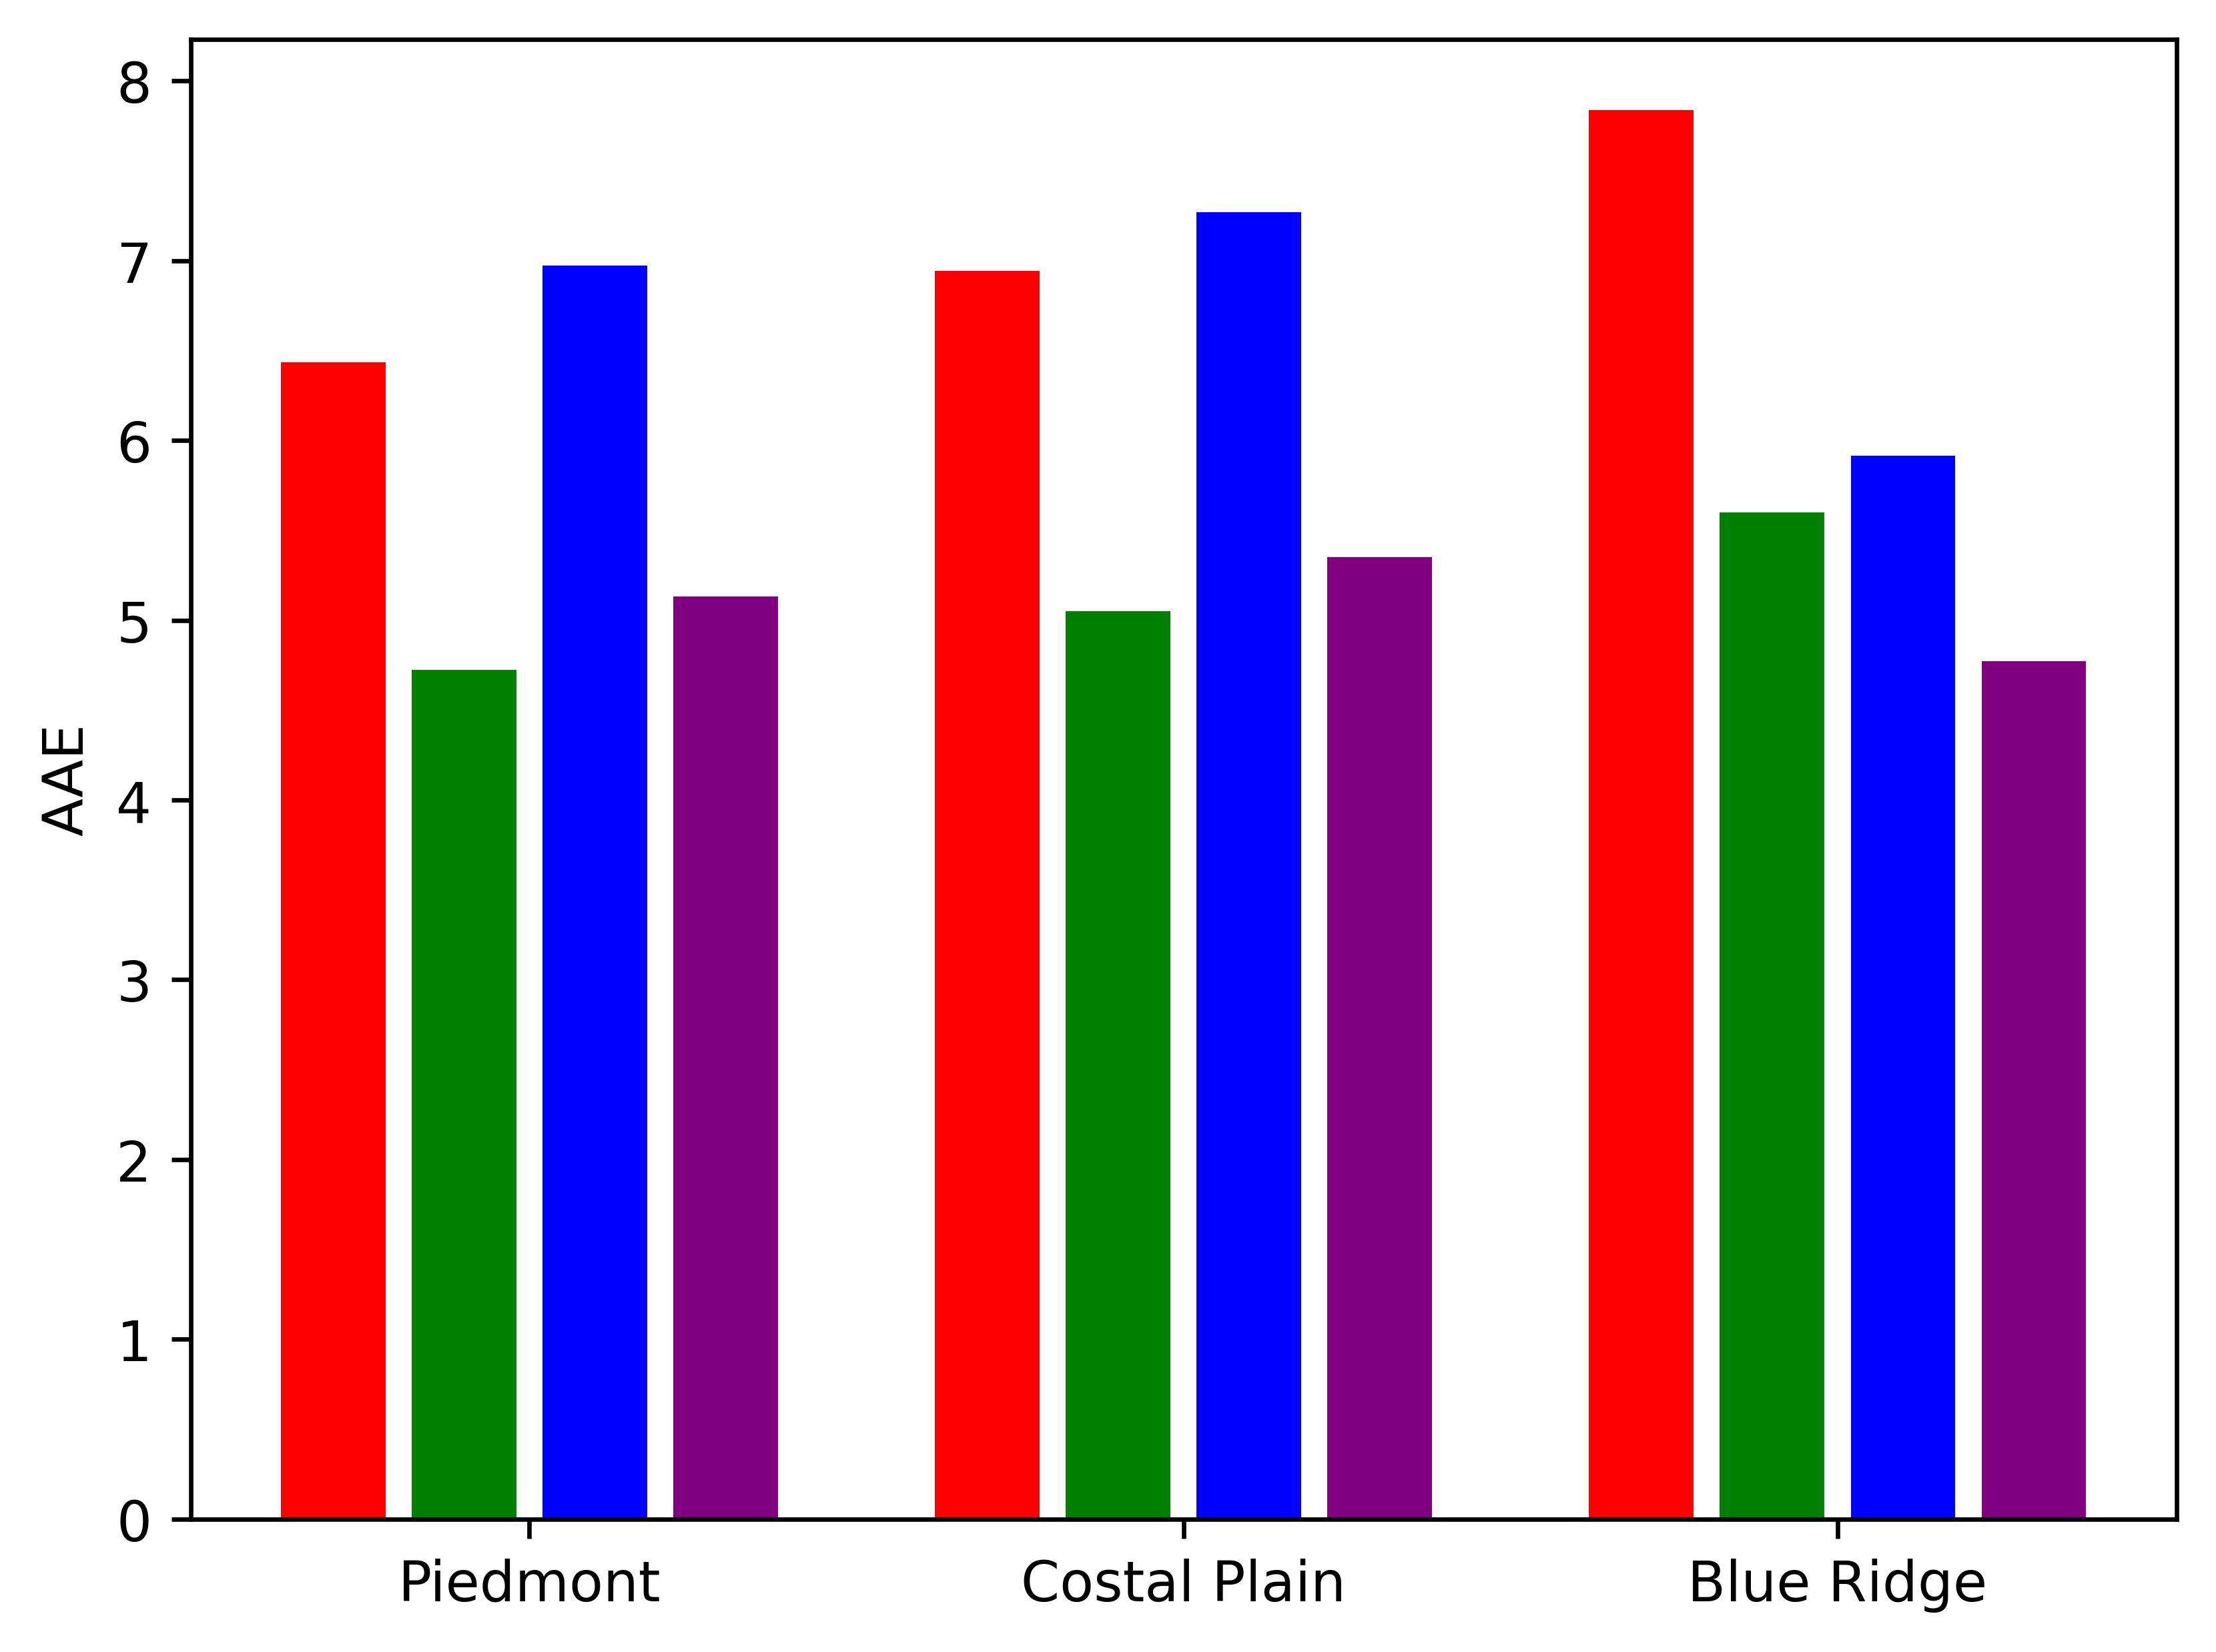

In [39]:
plt.bar(1,AAE_1[0] ,color='r')
plt.bar(2,AAE_1[-1],color='g')
plt.bar(3,AAE_2[0] ,color='b')
plt.bar(4,AAE_2[-1],color='#800080')

plt.bar(6,AAE_3[0],color='r')
plt.bar(7,AAE_3[-1],color='g')
plt.bar(8,AAE_4[0],color='b')
plt.bar(9,AAE_4[-1],color='#800080')

plt.bar(11,AAE_5[0],color='r')
plt.bar(12,AAE_5[-1],color='g')
plt.bar(13,AAE_6[0],color='b')
plt.bar(14,AAE_6[-1],color='#800080')
plt.ylabel('AAE')
plt.xticks([2.5, 7.5, 12.5], ['Piedmont', 'Costal Plain', 'Blue Ridge'])
plt.savefig('3.png')

In [19]:
fit_list = [fit_1,fit_2,fit_3,fit_4,fit_5,fit_5]

In [20]:
print(df_P_dry.index)

Index([800, 799, 798, 797, 796, 795, 794, 793, 792, 791,
       ...
       209, 208, 207, 206, 205, 204, 203, 202, 201, 200],
      dtype='int64', name='Wavelength (nm)', length=601)


In [85]:
#import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def mac_progression(df, main_ax,txt,legend=False):
    # Create inset_axes in the upper right corner, with separate x,y axis
    #axins = inset_axes(main_ax, width="35%", height="35%", loc=1)  # 1: upper right corner
    axins = inset_axes(main_ax, width="40%", height="40%", loc=1)  # for the BR vs BR chart
    

    vis = df[(df.index > 400) & (df.index <= 500)]

    uv = df[(df.index >= 280) & (df.index <= 400)]

    # For visible
    
    vis_data = vis.sum(axis=0) / vis.sum(axis=0)[0]
    uv_data = uv.sum(axis=0) / uv.sum(axis=0)[0]

    #axis
    axins.annotate(txt,xy=(0, 1.2), xycoords="axes fraction", 
               xytext=(10, -10), textcoords="offset points", 
               ha="left", va="top",)
    axins.plot(vis_data,  color='red',marker='x',label='Vis')
    #axins.scatter(vis_data.index, vis_data.values, color='red', s=15,marker='x',label='Vis')  # scatter plot for visible

    axins.plot(uv_data,  color='blue',marker='x',label='UV')
    #axins.scatter(uv_data.index, uv_data.values, color='blue', s=15,marker='x',label='UV')  # scatter plot for UV
    if legend:
        #axins.legend(loc=(0.6,0.8), fontsize='x-small',frameon=False)
        axins.legend(loc='center right', fontsize='small',frameon=False) ##for Br vs BR

    #axins.set_xlabel('Time (min)', fontsize='small')
    #axins.set_ylabel('Normlized Abs', fontsize='small')
    axins.set_ylabel('Normlized Abs')
    axins.set_xlabel('Time (min)')

    axins.tick_params(axis='both', which='both')
    axins.set_ylim((0.6,1.5))
    #axins.set_ylim((,1))

    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)

/var/folders/zh/6yg0122j0tlgz3_2t6x64jkh0000gn/T/ipykernel_15473/3353884911.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


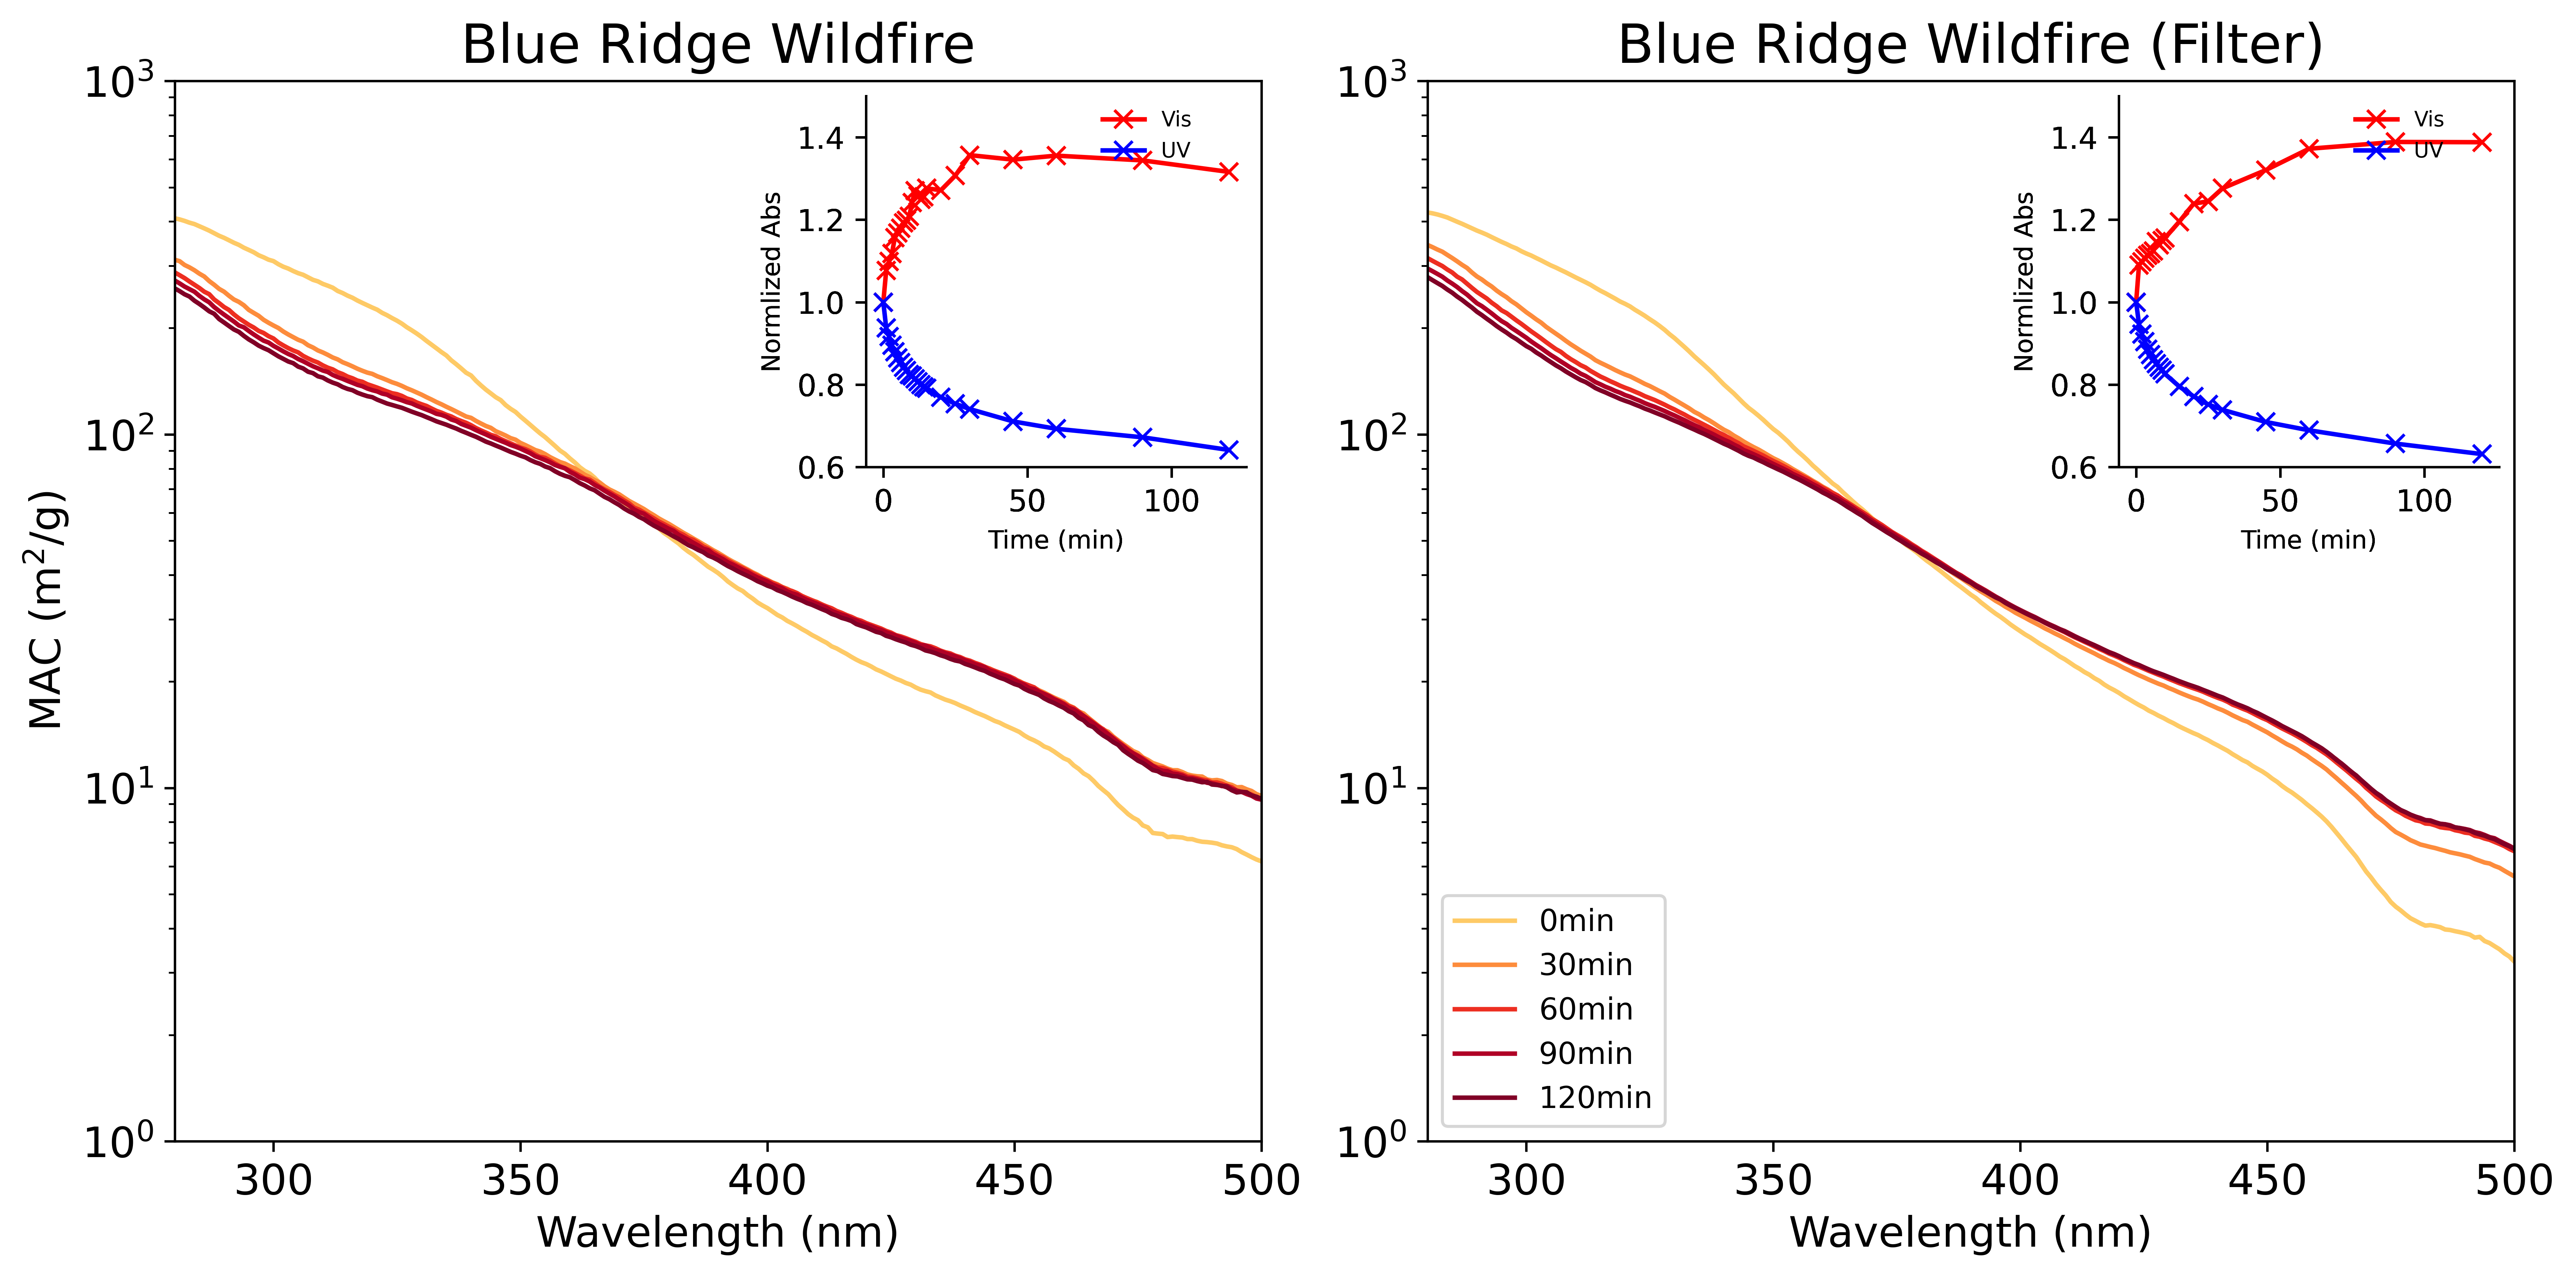

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6),sharex=True)
for idx, col in enumerate(col_list):
    ax[0].plot(df_BR_dry.index, 1e-2*df_BR_dry[col]/MAC_conv[4], label=str(col)+'min', color=colors[idx])
    ax[1].plot(df_BR_dry_beaker.index, 1e-2*df_BR_dry_beaker[col]/MAC_conv[6], label=str(col)+'min', color=colors[idx])
    mac_progression(df_BR_dry, ax[0],txt='',legend=True)
    mac_progression(df_BR_dry_beaker, ax[1],txt='',legend=True)
    ax[0].set_title('Blue Ridge Wildfire',fontsize=18)
    ax[1].set_title('Blue Ridge Wildfire (Filter)',fontsize=18)
ax[1].legend(loc='lower left')
for a in ax:
    a.set_xlim(280,500)
    a.set_ylim(1e0,1e3)
    a.set_yscale('log')
    a.set_xlabel('Wavelength (nm)',fontsize=14)
    a.tick_params(axis='both', which='major', labelsize=14)

ax[0].set_ylabel('MAC (m$^{2}$/g)',fontsize=14)
plt.tight_layout()
fig.savefig('S6.png')

Text(0, 0.5, 'MAC (cm$^{2}$/g)')

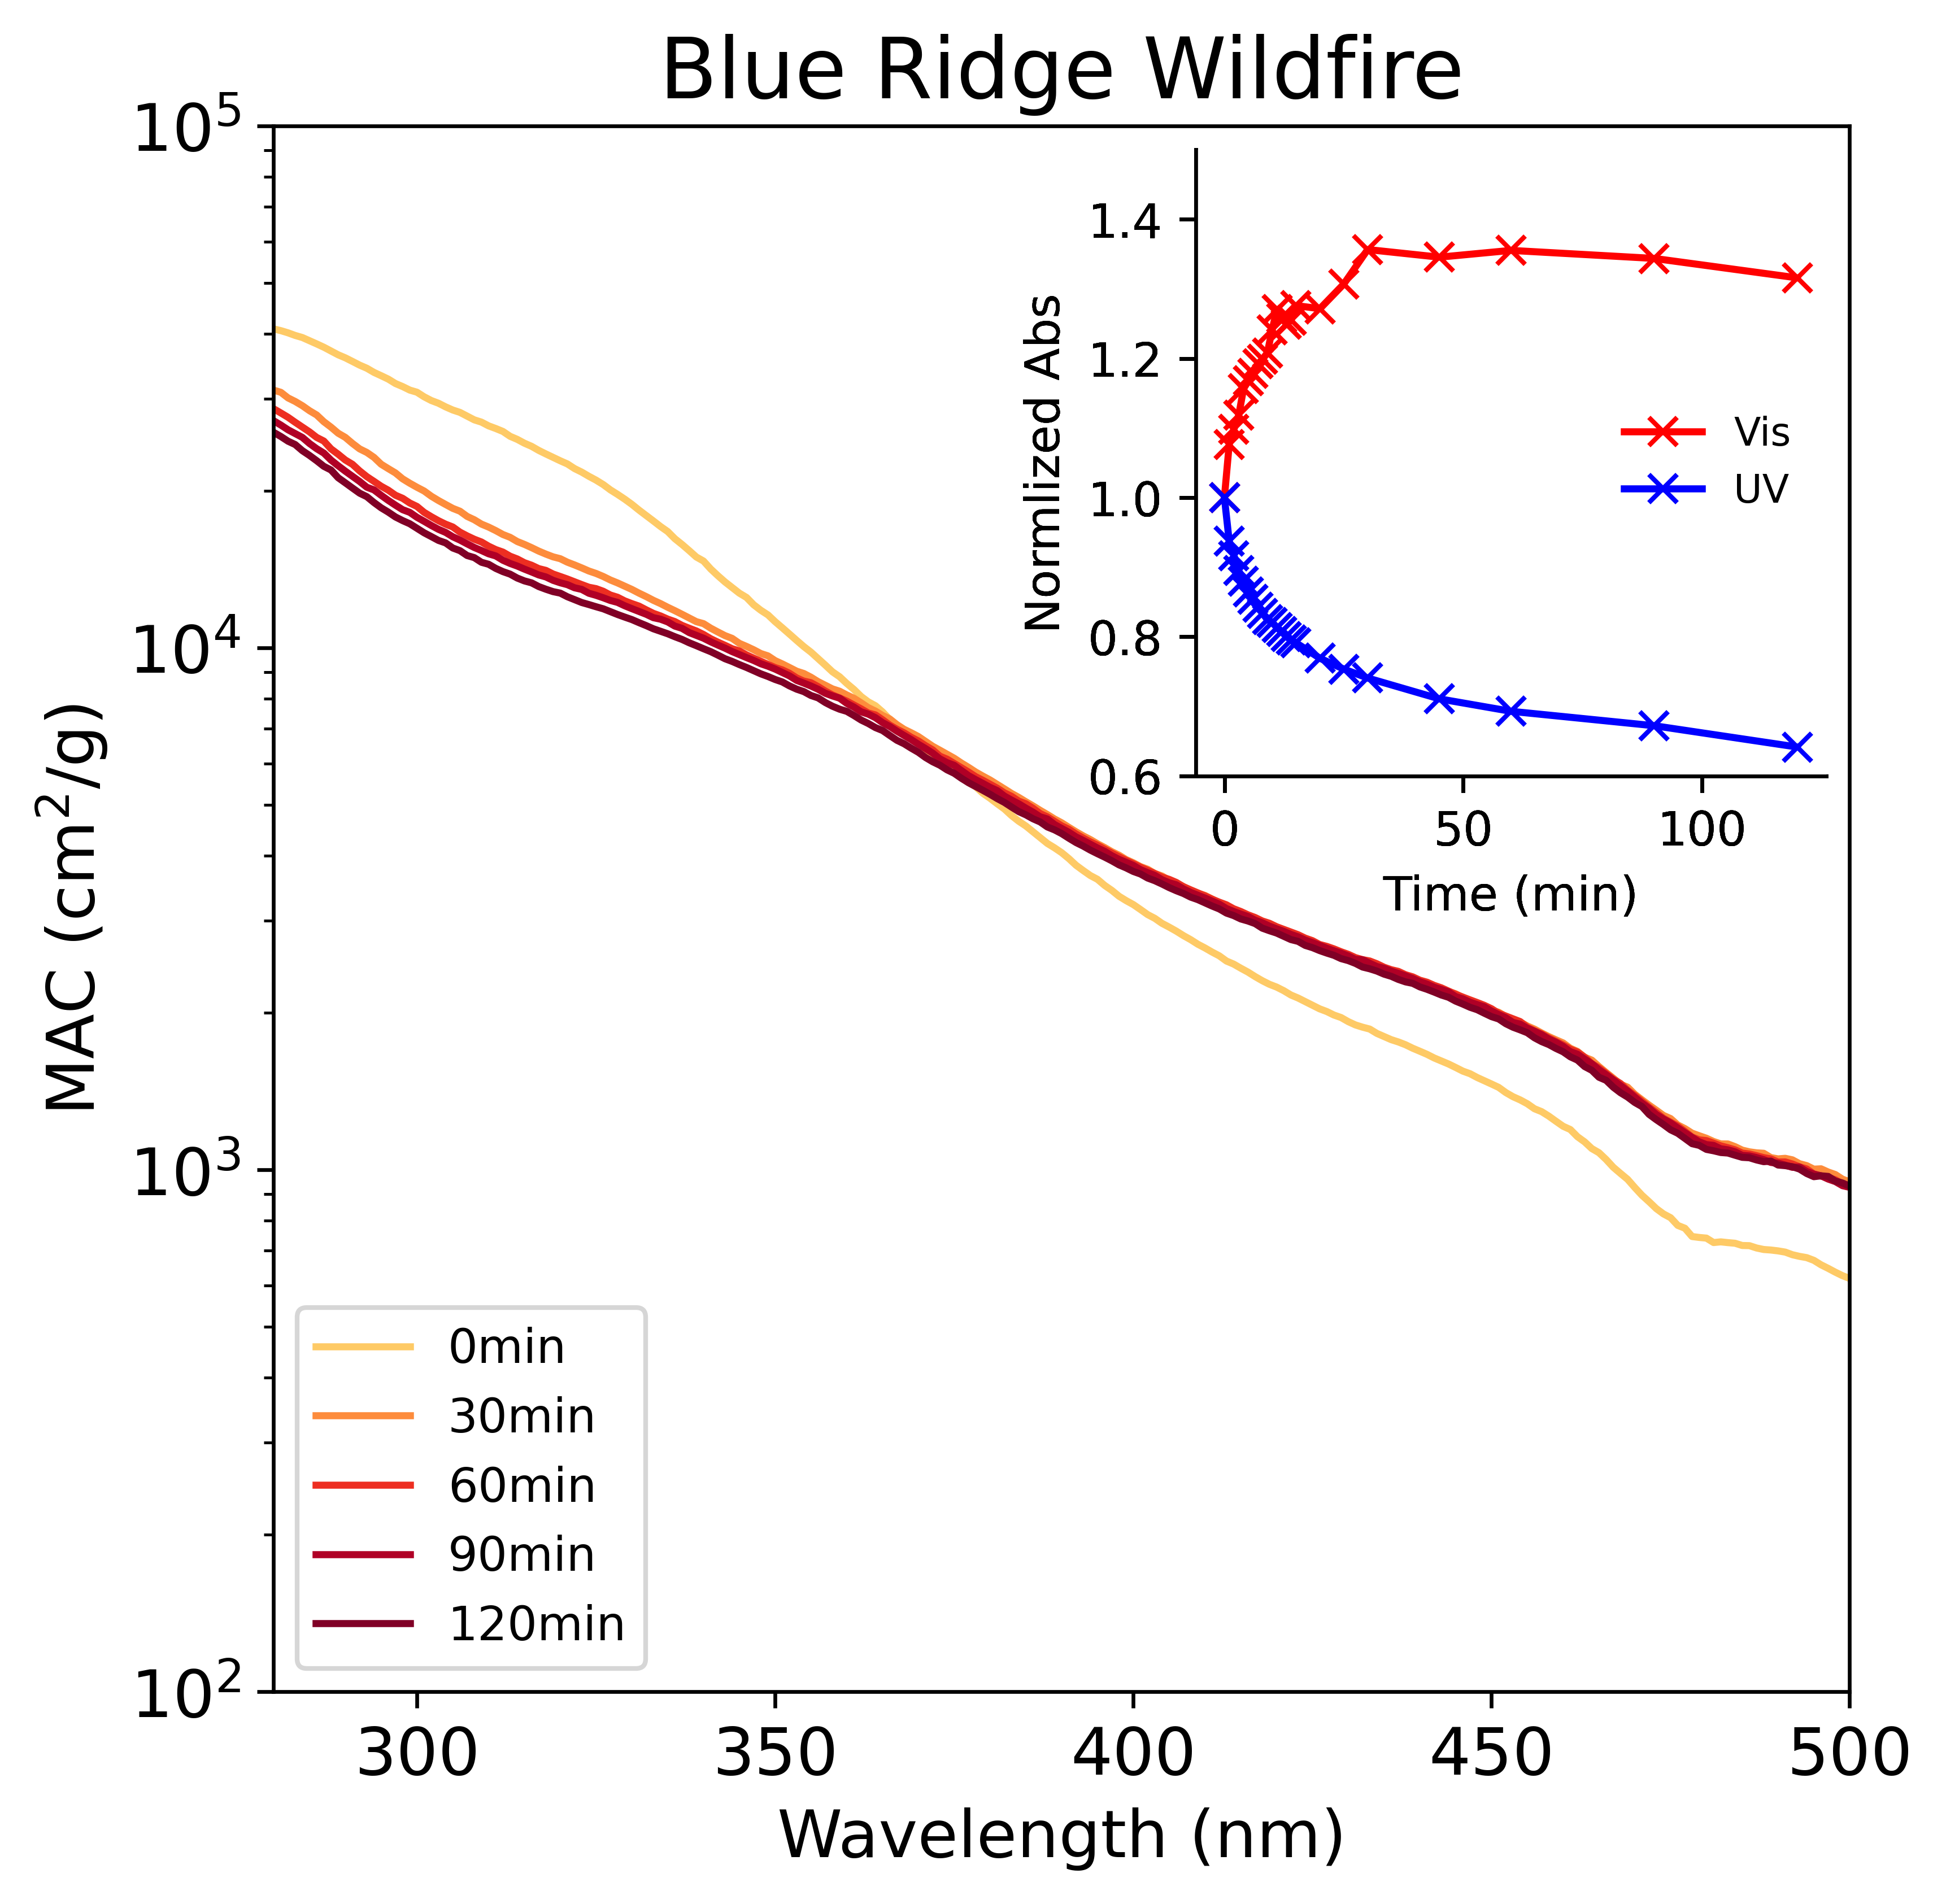

In [208]:
##this is for reviewers 
fig, ax = plt.subplots(1, 1, figsize=(6, 6),sharex=True)
for idx, col in enumerate(col_list):
    ax.plot(df_BR_dry.index, df_BR_dry[col]/MAC_conv[4], label=str(col)+'min', color=colors[idx])
    #ax[1].plot(df_BR_dry_beaker.index, df_BR_dry_beaker[col]/MAC_conv[6], label=str(col)+'min', color=colors[idx])
    mac_progression(df_BR_dry, ax,txt='',legend=True)
   # mac_progression(df_BR_dry_beaker, ax[1],txt='',legend=True)
    ax.set_title('Blue Ridge Wildfire',fontsize=18)
    #ax[1].set_title('Blue Ridge Wildfire (Filter)',fontsize=18)
ax.legend(loc='lower left')

ax.set_xlim(280,500)
ax.set_ylim(1e2,1e5)
ax.set_yscale('log')
ax.set_xlabel('Wavelength (nm)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylabel('MAC (cm$^{2}$/g)',fontsize=14)
